In [1]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, sum, lit, udf, greatest, mean as _mean, stddev as _stddev, max as spark_max
import numpy as np
import pandas as pd
from pyspark.sql.types import StringType
import re
import folium
from folium import plugins
import matplotlib.cm as cm
import matplotlib.colors as colors

In [ ]:
spark = SparkSession.builder \
    .appName("OnlineDatasetVis") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://namenode:9000") \
    .getOrCreate()

parquet_path = "hdfs://namenode:9000/user/hadoop/dane_przetworzone/online_training_dataset_with_offline_preds_final.parquet"
df = spark.read.parquet(parquet_path)

df.show(5)

pdf = df.toPandas()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/01 10:58:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/01 10:58:22 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/01 10:58:32 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
                                                                                

+-------------------+-----------+--------+---------+----+--------+--------+-----------+----------+--------+----+----+---+----+---+----+-----------+-----+----+--------+--------+--------+--------+-------+-------+------+------+-------+-------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+------------------------

In [3]:
row_count = df.count()
print(f"Liczba wierszy: {row_count}")
col_count = len(df.columns)
print(f"Liczba kolumn: {col_count}")

null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts.show(vertical=True)

Liczba wierszy: 210
Liczba kolumn: 72
-RECORD 0------------------------------
 datetime_utc                    | 0   
 temperature                     | 0   
 humidity                        | 0   
 dew_point                       | 0   
 rain                            | 0   
 snowfall                        | 0   
 pressure                        | 0   
 cloud_cover                     | 0   
 wind_speed                      | 0   
 wind_dir                        | 0   
 pm10                            | 0   
 pm25                            | 0   
 no2                             | 0   
 o3                              | 0   
 so2                             | 0   
 hour                            | 0   
 day_of_week                     | 0   
 month                           | 0   
 year                            | 0   
 pm10_t-1                        | 0   
 pm10_t+1                        | 0   
 pm25_t-1                        | 0   
 pm25_t+1                        | 0   
 n

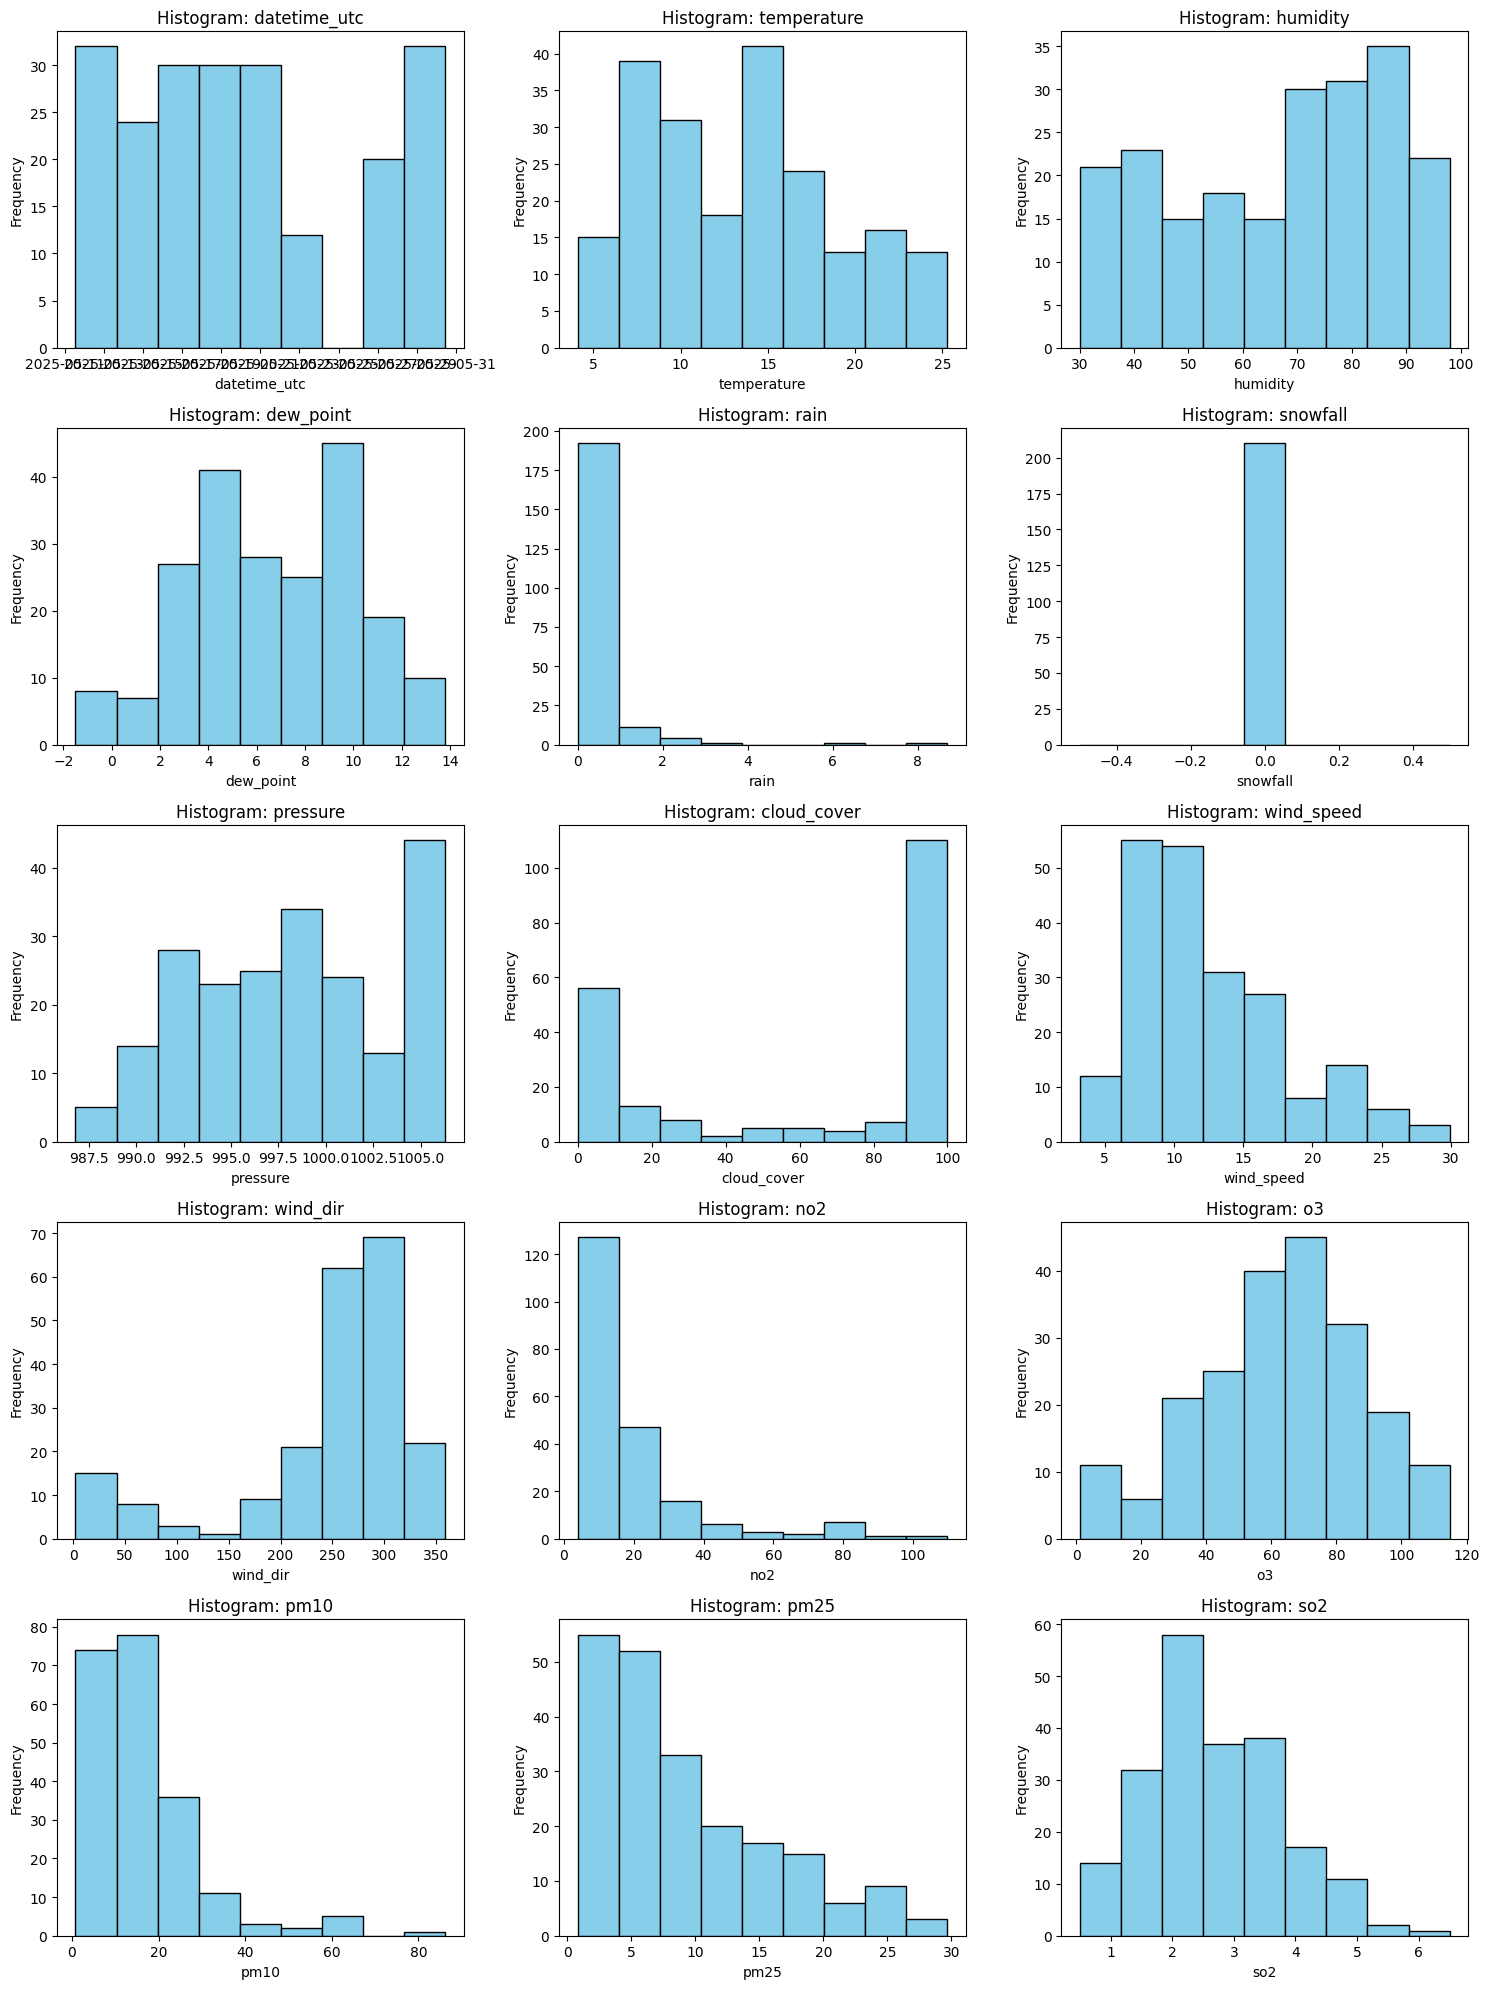

In [ ]:
columns_to_plot = ['datetime_utc', 'temperature', 'humidity', 'dew_point', 'rain', 'snowfall', 'pressure', 'cloud_cover', 'wind_speed', 'wind_dir', 'no2', 'o3', 'pm10', 'pm25', 'so2']  # wpisz swoje kolumny numeryczne

def calculate_bins(data):
    n = len(data)
    bins = int(np.ceil(np.log2(n) + 1))
    return bins

n_cols = 3
n_plots = len(columns_to_plot)
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for i, col_name in enumerate(columns_to_plot):
    data = df.select(col_name).dropna().toPandas()[col_name]
    bins = calculate_bins(data)
    axes[i].hist(data, bins=bins, color='skyblue', edgecolor='black')
    
    axes[i].set_title(f'Histogram: {col_name}')
    axes[i].set_xlabel(col_name)
    axes[i].set_ylabel('Frequency')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

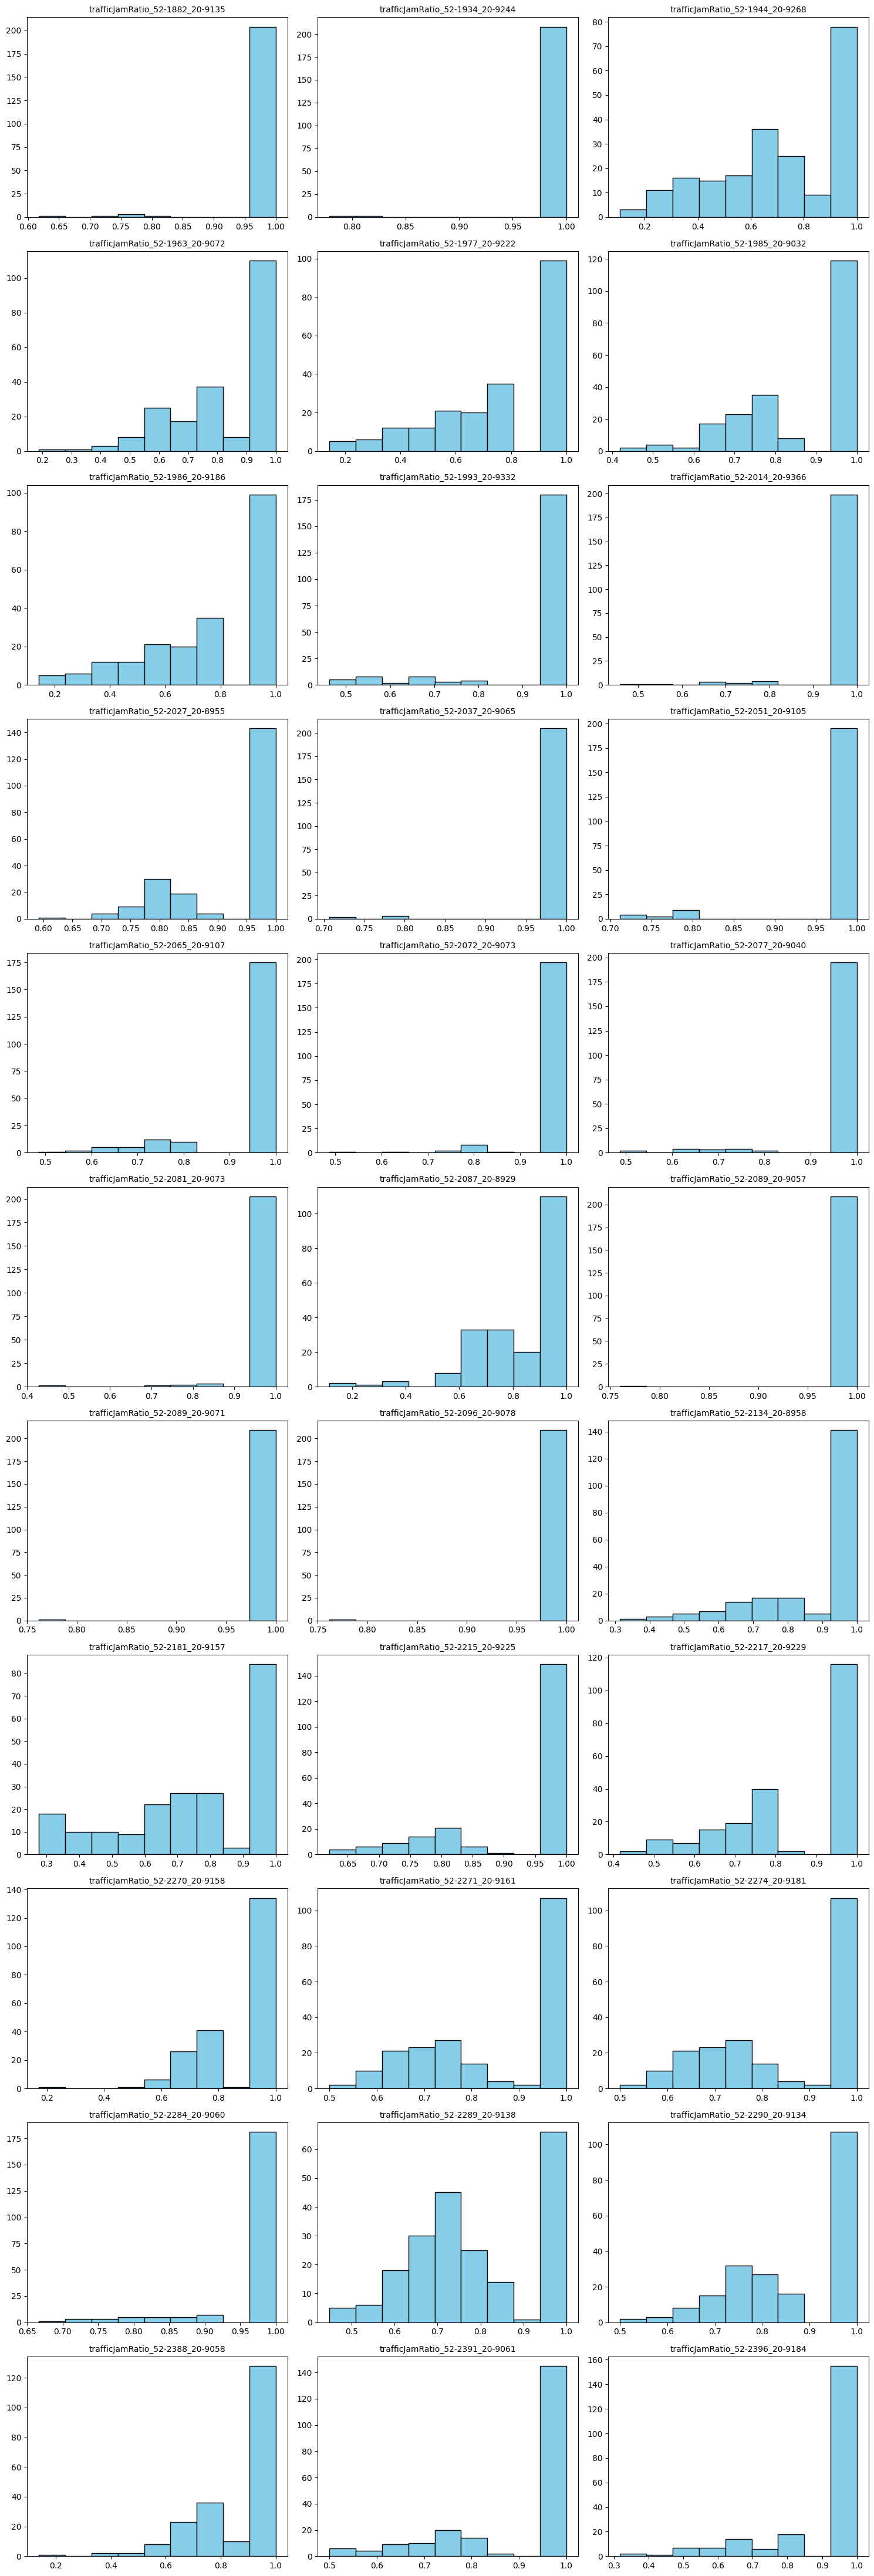

In [ ]:
traffic_jam_columns = [col for col in df.columns if col.startswith('trafficJamRatio_')]

def calculate_bins(data):
    """Reguła Sturgesa – liczba binów."""
    n = len(data)
    return int(np.ceil(np.log2(n) + 1)) if n > 0 else 1

n_cols = 3
n_plots = len(traffic_jam_columns)
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, col_name in enumerate(traffic_jam_columns):
    data = df.select(col_name).dropna().toPandas()[col_name]
    bins = calculate_bins(data)

    axes[i].hist(data, bins=bins, color='skyblue', edgecolor='black')
    axes[i].set_title(col_name, fontsize=10)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

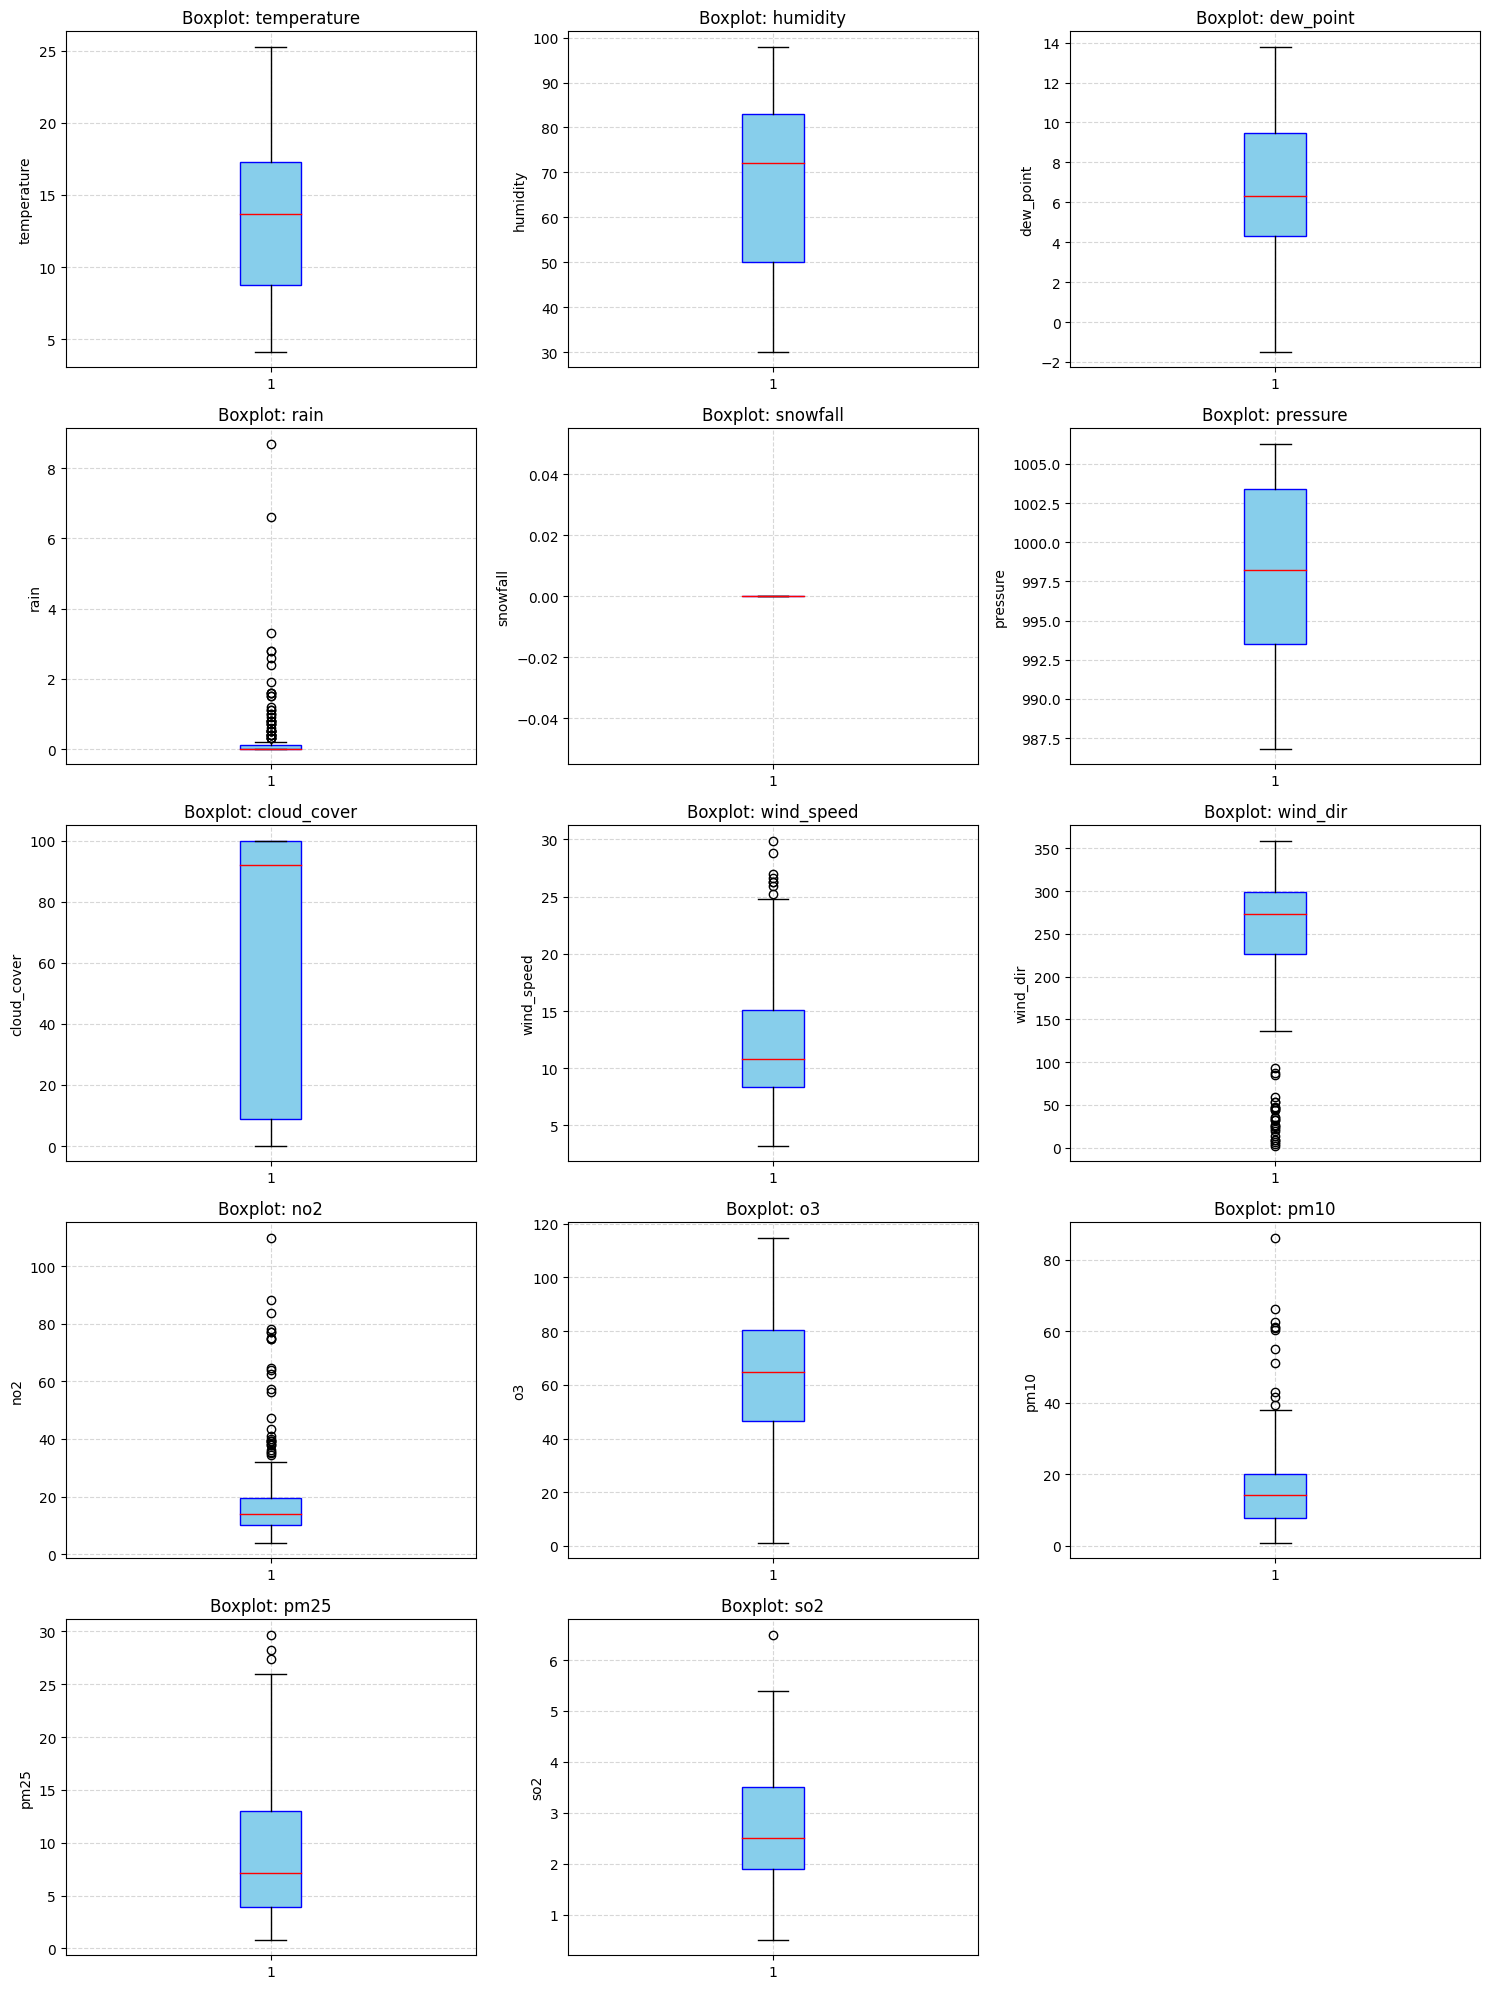

In [ ]:
columns_to_plot = ['temperature', 'humidity', 'dew_point', 'rain', 'snowfall', 
                   'pressure', 'cloud_cover', 'wind_speed', 'wind_dir', 
                   'no2', 'o3', 'pm10', 'pm25', 'so2']

n_cols = 3
n_plots = len(columns_to_plot)
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, col_name in enumerate(columns_to_plot):
    data = df.select(col_name).dropna().toPandas()[col_name]
    
    axes[i].boxplot(data, patch_artist=True,
                    boxprops=dict(facecolor='skyblue', color='blue'),
                    medianprops=dict(color='red'))
    axes[i].set_title(f'Boxplot: {col_name}')
    axes[i].set_ylabel(col_name)
    axes[i].grid(True, linestyle='--', alpha=0.5)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

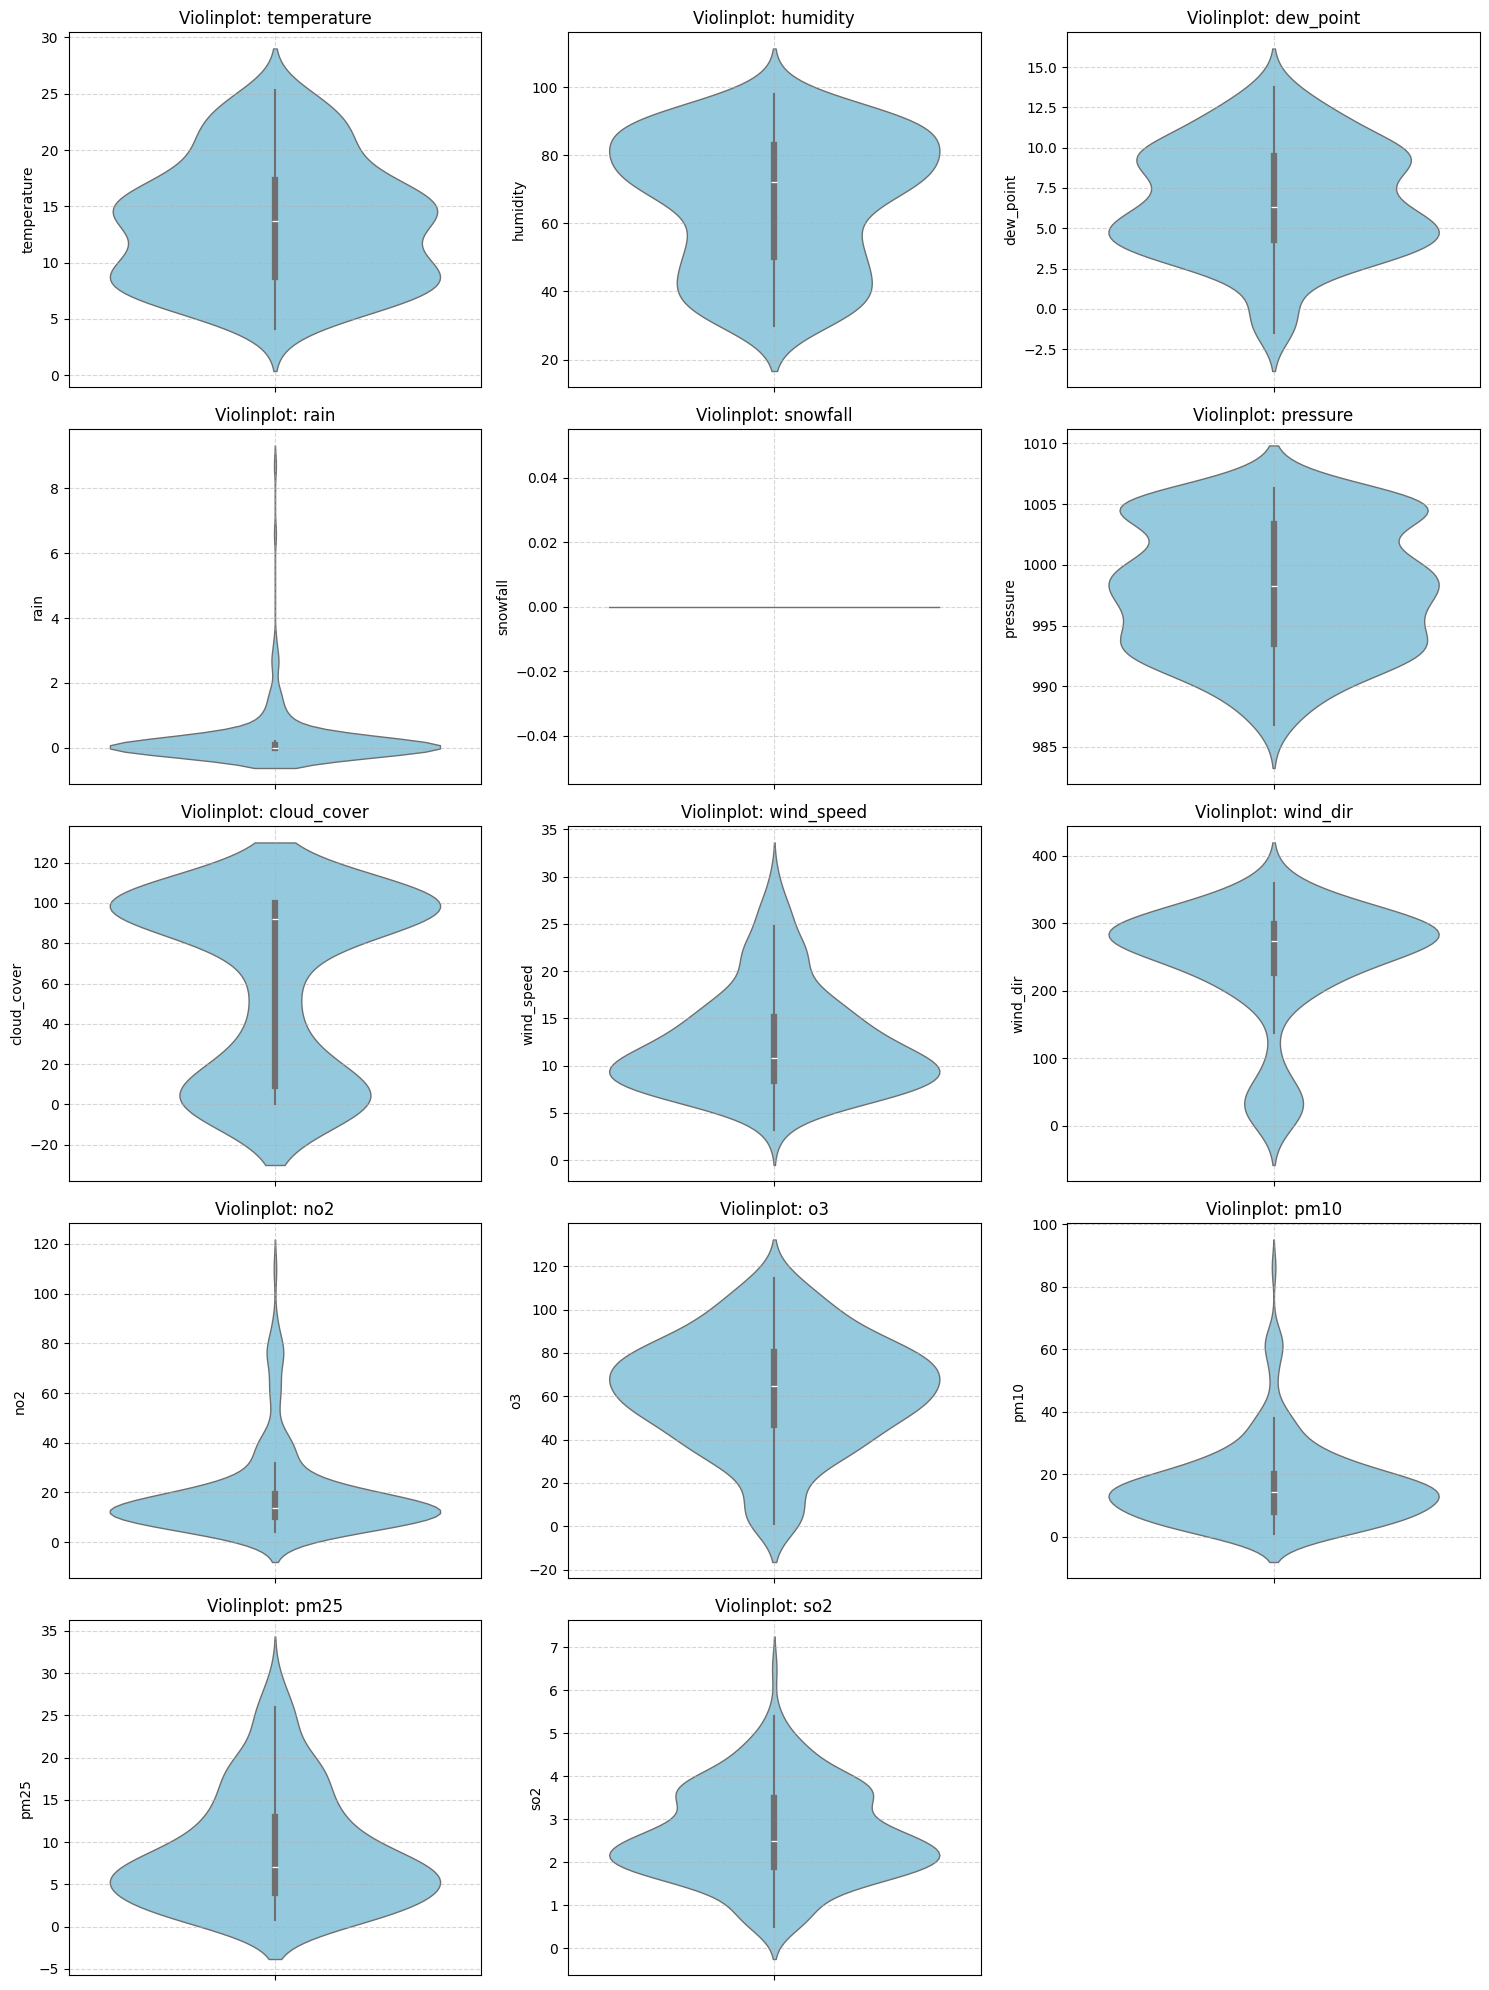

In [ ]:
columns_to_plot = ['temperature', 'humidity', 'dew_point', 'rain', 'snowfall', 
                   'pressure', 'cloud_cover', 'wind_speed', 'wind_dir', 
                   'no2', 'o3', 'pm10', 'pm25', 'so2']

n_cols = 3
n_plots = len(columns_to_plot)
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, col_name in enumerate(columns_to_plot):
    data = df.select(col_name).dropna().toPandas()[col_name]

    sns.violinplot(y=data, ax=axes[i], inner='box', color='skyblue', linewidth=1)
    axes[i].set_title(f'Violinplot: {col_name}')
    axes[i].set_ylabel(col_name)
    axes[i].grid(True, linestyle='--', alpha=0.5)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

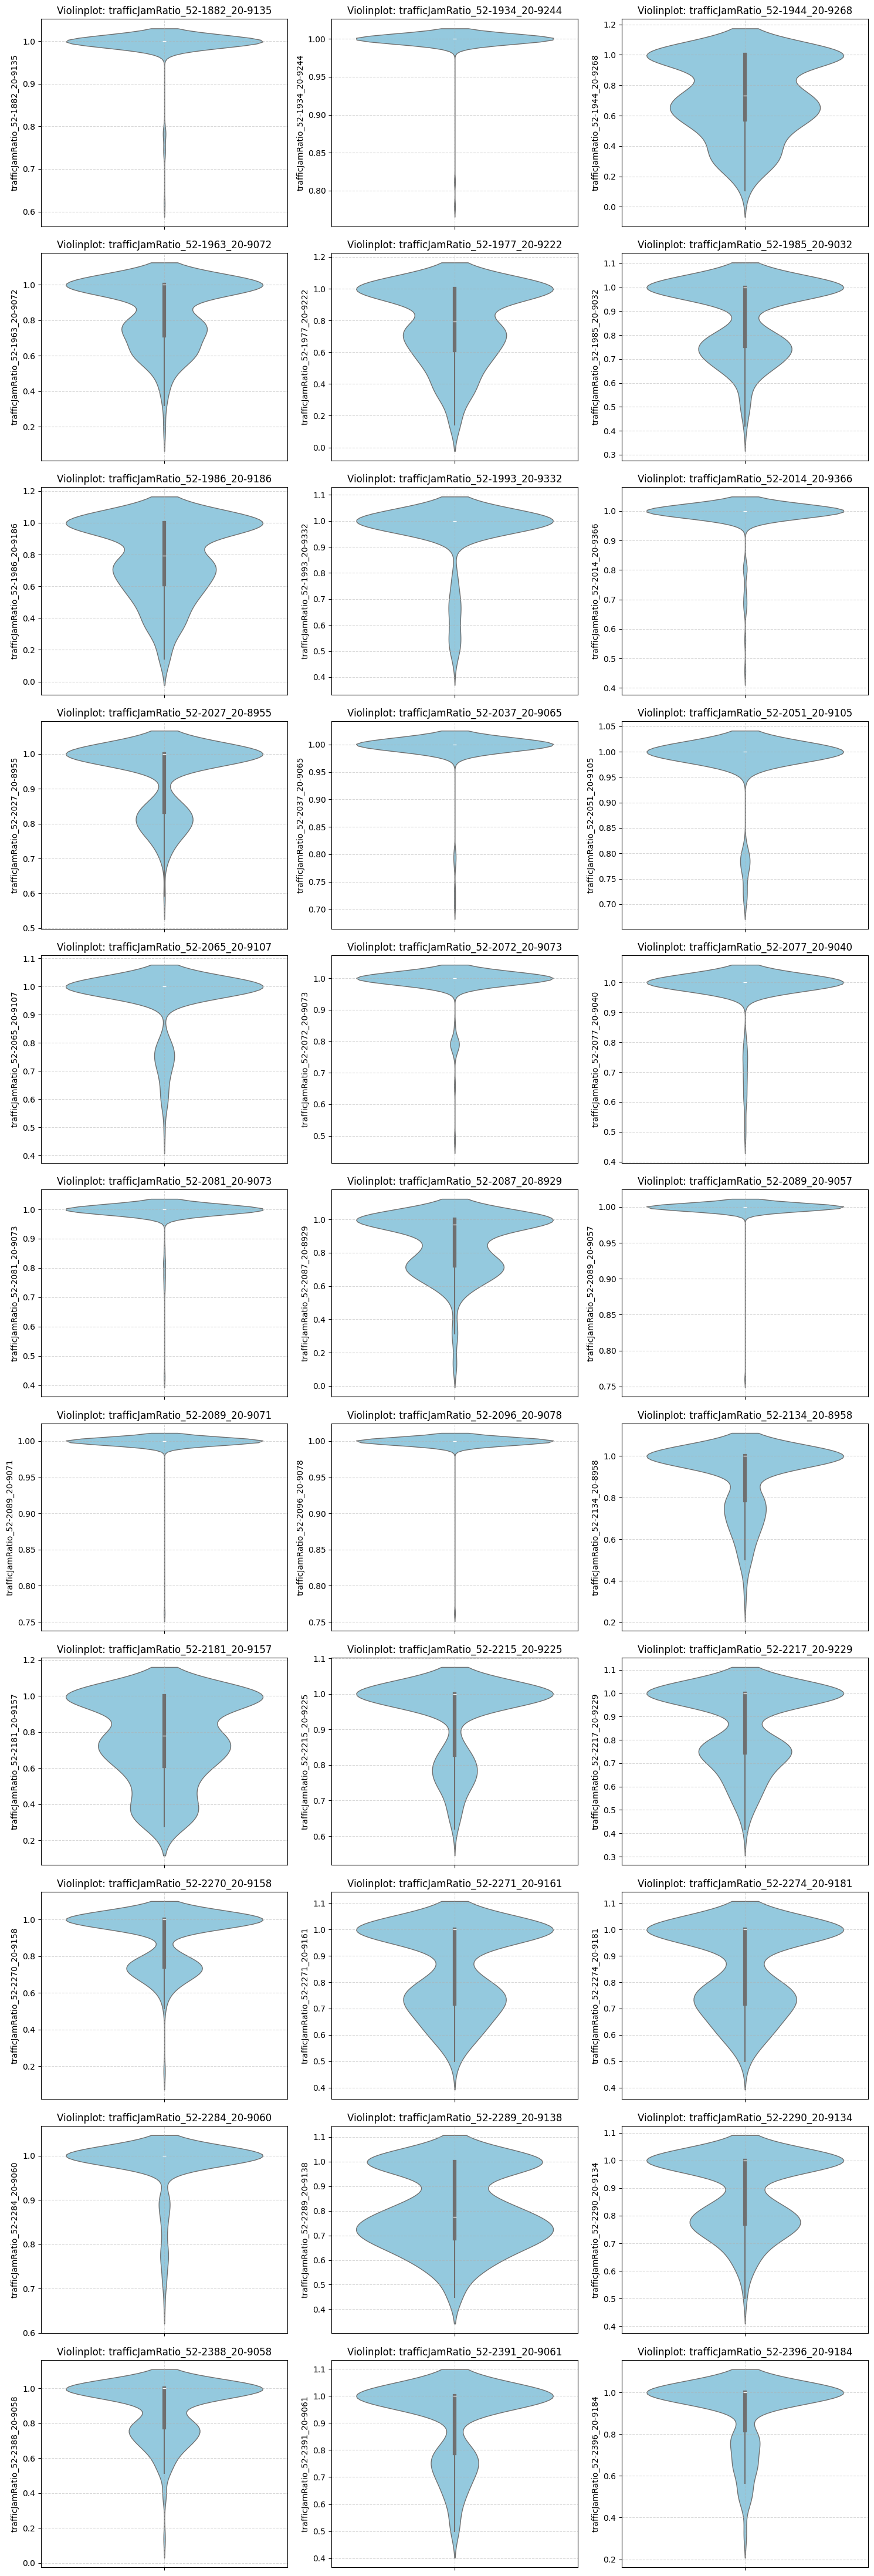

In [ ]:
n_cols = 3
n_plots = len(traffic_jam_columns)
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, col_name in enumerate(traffic_jam_columns):
    data = df.select(col_name).dropna().toPandas()[col_name]

    sns.violinplot(y=data, ax=axes[i], inner='box', color='skyblue', linewidth=1)
    axes[i].set_title(f'Violinplot: {col_name}')
    axes[i].set_ylabel(col_name)
    axes[i].grid(True, linestyle='--', alpha=0.5)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [9]:
pollutants = ['pm10', 'pm25', 'no2', 'o3', 'so2']
for poll_col in pollutants:
    count = (pdf[poll_col] < 0).sum()
    print(f'{poll_col}: {count} wartości poniżej zera')

pm10: 0 wartości poniżej zera
pm25: 0 wartości poniżej zera
no2: 0 wartości poniżej zera
o3: 0 wartości poniżej zera
so2: 0 wartości poniżej zera


In [ ]:
pollutants = ['pm10', 'pm25', 'no2', 'so2', 'o3']

for pol in pollutants:
    q = df.approxQuantile(pol, [0.99], 0.00)
    count = df.filter(col(pol) > q[0]).count()
    print(f"{pol.upper():<5} | 99. percentyl: {q[0]:.2f} | rekordów powyżej: {count}")

print("-------------------------------------")

for pol in pollutants:
    q = df.approxQuantile(pol, [0.98], 0.00)
    count = df.filter(col(pol) > q[0]).count()
    print(f"{pol.upper():<5} | 98. percentyl: {q[0]:.2f} | rekordów powyżej: {count}")

PM10  | 99. percentyl: 86.20 | rekordów powyżej: 0
PM25  | 99. percentyl: 29.70 | rekordów powyżej: 0
NO2   | 99. percentyl: 109.90 | rekordów powyżej: 0
SO2   | 99. percentyl: 6.50 | rekordów powyżej: 0
O3    | 99. percentyl: 114.80 | rekordów powyżej: 0
-------------------------------------
PM10  | 98. percentyl: 60.80 | rekordów powyżej: 4
PM25  | 98. percentyl: 25.90 | rekordów powyżej: 4
NO2   | 98. percentyl: 77.10 | rekordów powyżej: 4
SO2   | 98. percentyl: 4.90 | rekordów powyżej: 4
O3    | 98. percentyl: 111.80 | rekordów powyżej: 4


In [24]:
pollutants = ['pm10', 'pm25', 'no2', 'so2', 'o3']
percentiles_98 = {}

for pol in pollutants:
    q = df.approxQuantile(pol, [0.98], 0.00)
    percentiles_98[pol] = q[0]
    print(f"{pol}: 98. percentyl = {q[0]:.2f}")

pm10: 98. percentyl = 60.80
pm25: 98. percentyl = 25.90
no2: 98. percentyl = 77.10
so2: 98. percentyl = 4.90
o3: 98. percentyl = 111.80


In [ ]:
all_cols = df.columns
cols_to_check = []

for pol in pollutants:
    for c in all_cols:
        if c == pol or c.startswith(pol + '_t'):
            cols_to_check.append((c, pol))

In [ ]:
from functools import reduce

filter_condition = reduce(
    lambda acc, pair: acc & (col(pair[0]) <= percentiles_98[pair[1]]),
    cols_to_check,
    col(cols_to_check[0][0]) <= percentiles_98[cols_to_check[0][1]]
)

filtered_df = df.filter(filter_condition)
print(f"Liczba rekordów po filtracji: {filtered_df.count()}")

Liczba rekordów po filtracji: 184


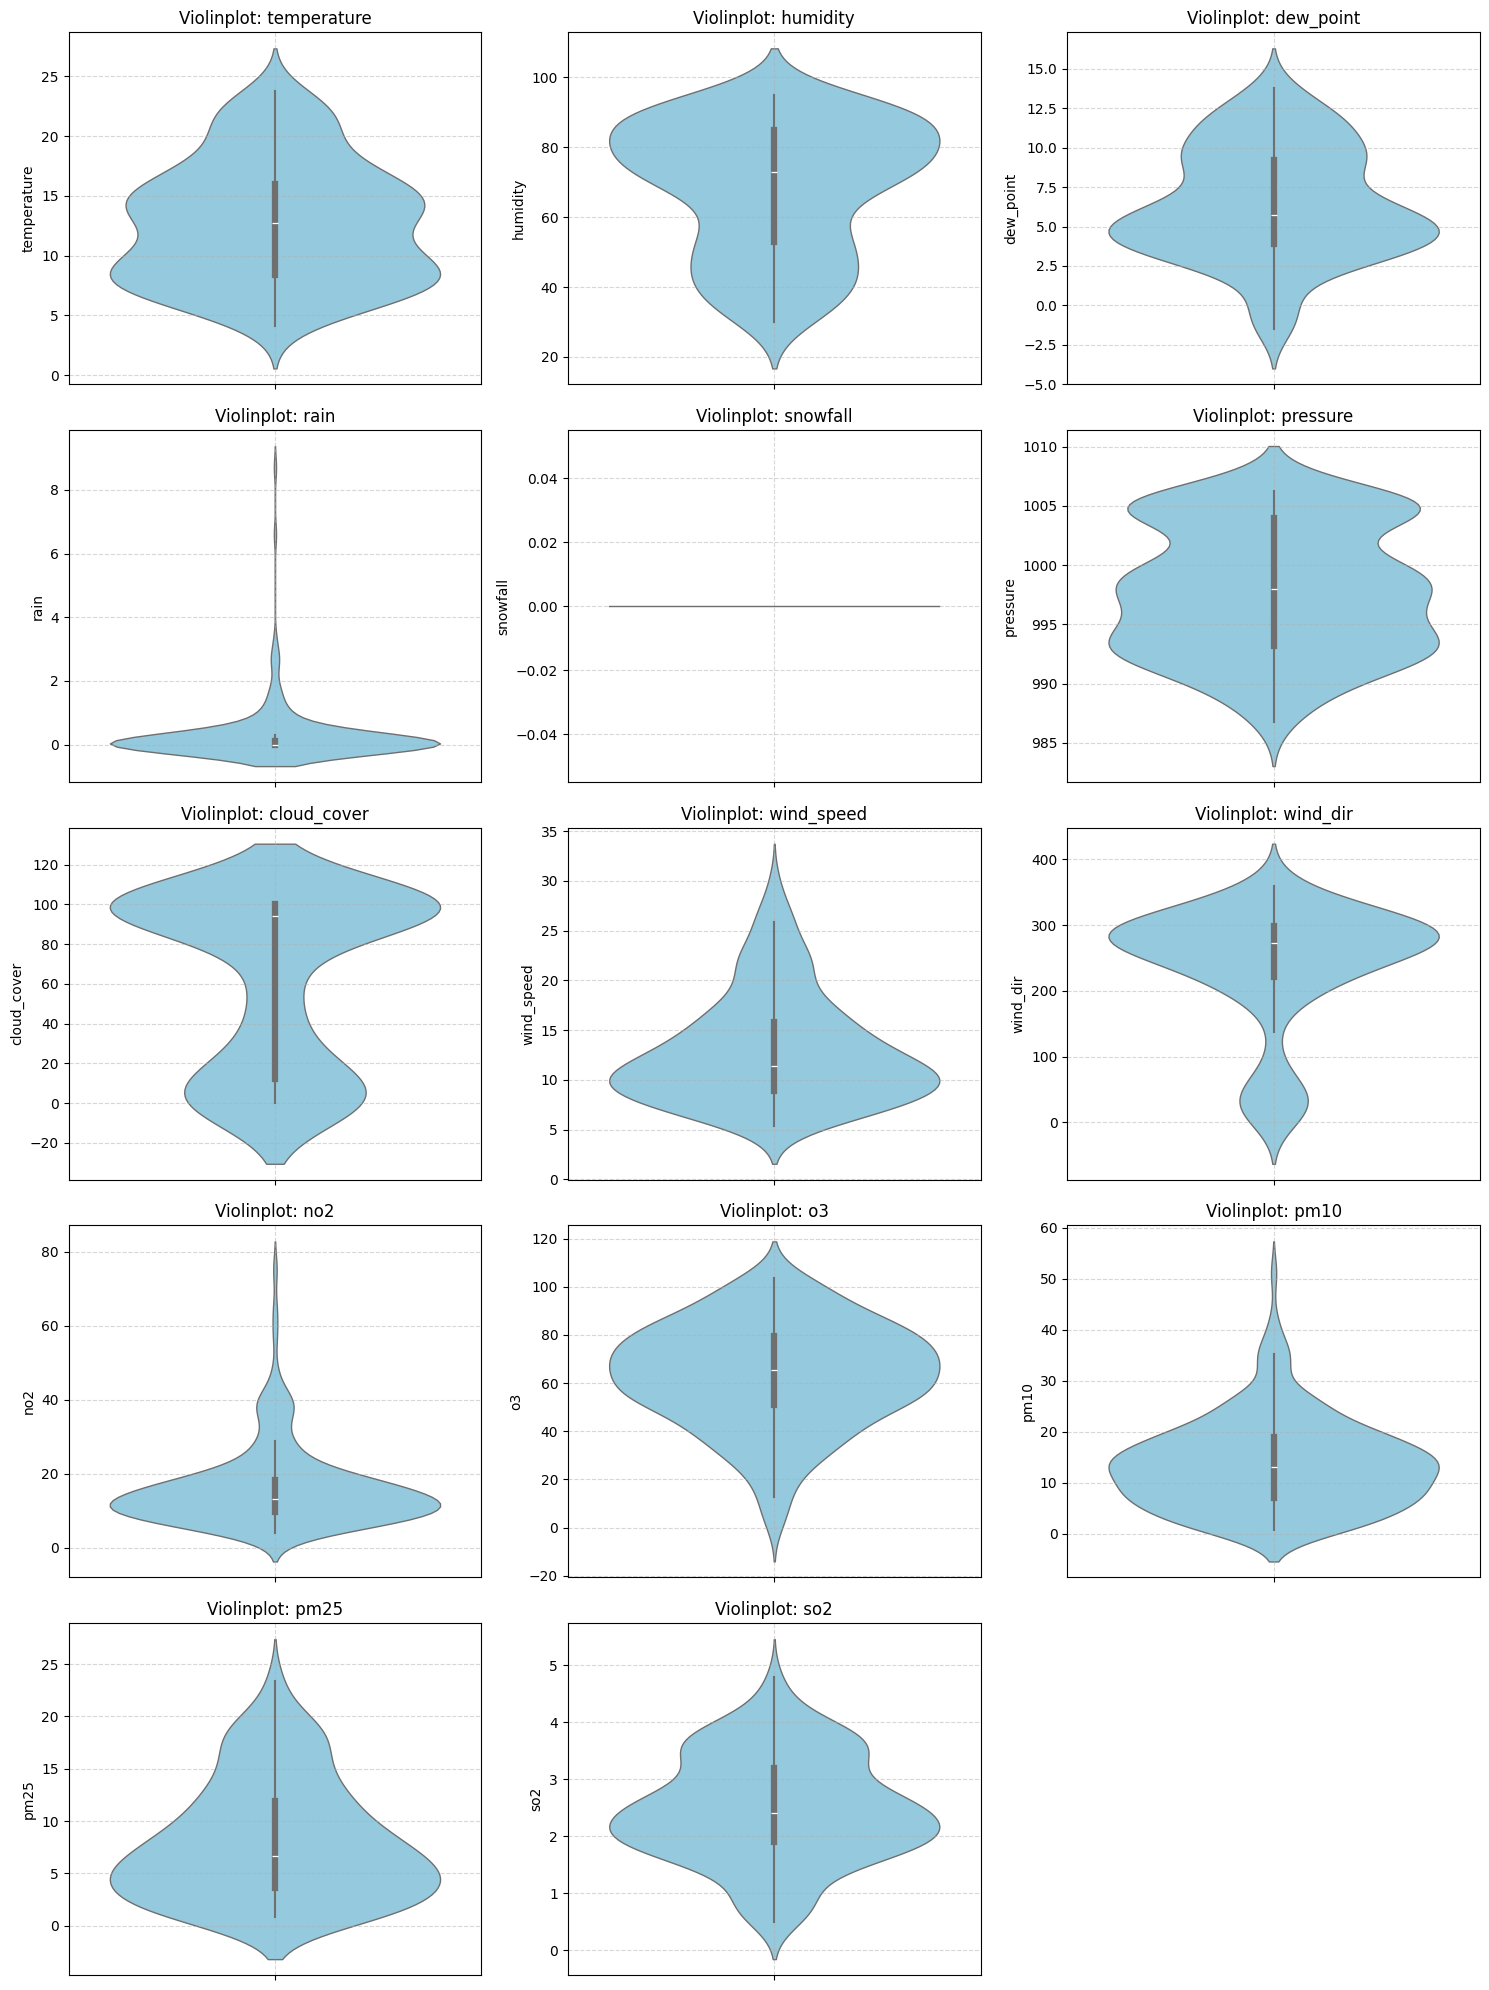

In [ ]:
columns_to_plot = ['temperature', 'humidity', 'dew_point', 'rain', 'snowfall', 
                   'pressure', 'cloud_cover', 'wind_speed', 'wind_dir', 
                   'no2', 'o3', 'pm10', 'pm25', 'so2']

n_cols = 3
n_plots = len(columns_to_plot)
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, col_name in enumerate(columns_to_plot):
    data = filtered_df.select(col_name).dropna().toPandas()[col_name]

    sns.violinplot(y=data, ax=axes[i], inner='box', color='skyblue', linewidth=1)
    axes[i].set_title(f'Violinplot: {col_name}')
    axes[i].set_ylabel(col_name)
    axes[i].grid(True, linestyle='--', alpha=0.5)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
traffic_jam_columns = [column for column in df.columns if column.startswith('trafficJamRatio_')]

markers = []

for column in traffic_jam_columns:
    match = re.search(r'trafficJamRatio_(\d+)-(\d+)_(\d+)-(\d+)', column)
    if match:
        lat = float(match.group(1) + '.' + match.group(2))
        lon = float(match.group(3) + '.' + match.group(4))
        mean_value = df.select(column).agg({column: 'avg'}).first()[0]
        if mean_value is not None:
            markers.append({'lat': lat, 'lon': lon, 'value': mean_value})

In [ ]:
norm = colors.Normalize(
    vmin=min(m['value'] for m in markers),
    vmax=max(m['value'] for m in markers)
)

cmap = cm.get_cmap('RdYlGn')

map_warsaw = folium.Map(location=[52.207742, 20.906073], zoom_start=12)

folium.Marker(
    location=[52.207742, 20.906073],
    popup='Stacja pomiarowa',
    icon=folium.Icon(color='purple', icon='glyphicon glyphicon-tint')
).add_to(map_warsaw)

for m in markers:
    color = colors.to_hex(cmap(norm(m['value'])))
    folium.CircleMarker(
        location=(m['lat'], m['lon']),
        radius=10,
        color='black',
        weight=2,
        fill=True,
        fill_color=color,
        fill_opacity=0.9,
        popup=f"{m['lat']}, {m['lon']}<br>TrafficJamRatio: {m['value']:.2f}"
    ).add_to(map_warsaw)

map_warsaw

/tmp/ipykernel_6286/3459499486.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlGn')  # normalna wersja (zielony = max)


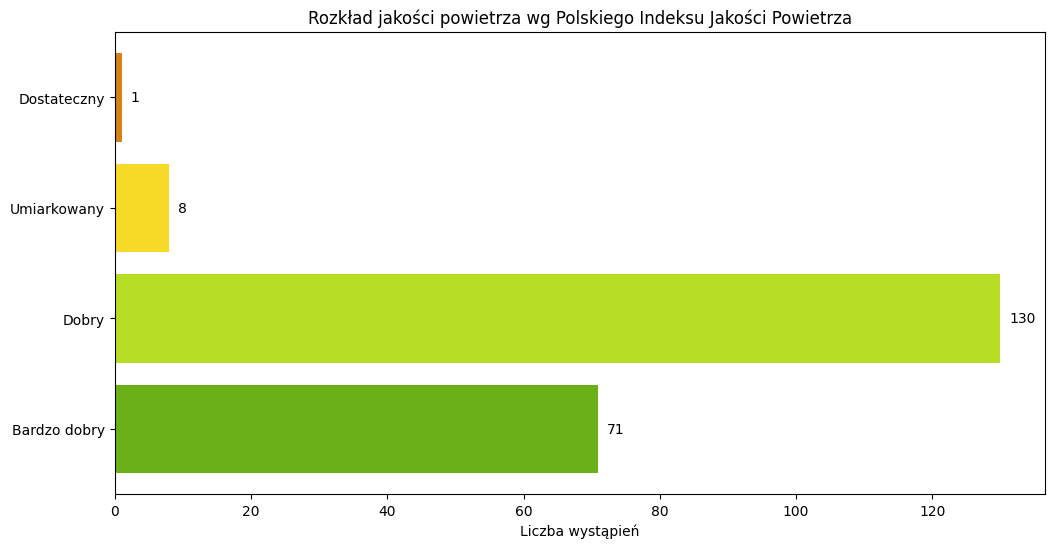

In [ ]:
def air_quality_index(value, pollutant):
    if value is None:
        return "Brak indeksu"
    if pollutant == 'pm10':
        if 0 <= value <= 20: return "Bardzo dobry"
        elif 20.1 <= value <= 50: return "Dobry"
        elif 50.1 <= value <= 80: return "Umiarkowany"
        elif 80.1 <= value <= 110: return "Dostateczny"
        elif 110.1 <= value <= 150: return "Zły"
        elif value > 150: return "Bardzo zły"
    elif pollutant == 'pm25':
        if 0 <= value <= 13: return "Bardzo dobry"
        elif 13.1 <= value <= 35: return "Dobry"
        elif 35.1 <= value <= 55: return "Umiarkowany"
        elif 55.1 <= value <= 75: return "Dostateczny"
        elif 75.1 <= value <= 110: return "Zły"
        elif value > 110: return "Bardzo zły"
    elif pollutant == 'o3':
        if 0 <= value <= 70: return "Bardzo dobry"
        elif 70.1 <= value <= 120: return "Dobry"
        elif 120.1 <= value <= 150: return "Umiarkowany"
        elif 150.1 <= value <= 180: return "Dostateczny"
        elif 180.1 <= value <= 240: return "Zły"
        elif value > 240: return "Bardzo zły"
    elif pollutant == 'no2':
        if 0 <= value <= 40: return "Bardzo dobry"
        elif 40.1 <= value <= 100: return "Dobry"
        elif 100.1 <= value <= 150: return "Umiarkowany"
        elif 150.1 <= value <= 230: return "Dostateczny"
        elif 230.1 <= value <= 400: return "Zły"
        elif value > 400: return "Bardzo zły"
    elif pollutant == 'so2':
        if 0 <= value <= 50: return "Bardzo dobry"
        elif 50.1 <= value <= 100: return "Dobry"
        elif 100.1 <= value <= 200: return "Umiarkowany"
        elif 200.1 <= value <= 350: return "Dostateczny"
        elif 350.1 <= value <= 500: return "Zły"
        elif value > 500: return "Bardzo zły"
    return "Brak indeksu"

air_quality_udf = udf(air_quality_index, StringType())

df_index = df.withColumn("pm10_index", air_quality_udf(col("pm10"), lit("pm10"))) \
       .withColumn("pm25_index", air_quality_udf(col("pm25"), lit("pm25"))) \
       .withColumn("o3_index", air_quality_udf(col("o3"), lit("o3"))) \
       .withColumn("no2_index", air_quality_udf(col("no2"), lit("no2"))) \
       .withColumn("so2_index", air_quality_udf(col("so2"), lit("so2")))

quality_rank = {
    "Brak indeksu": 0,
    "Bardzo dobry": 1,
    "Dobry": 2,
    "Umiarkowany": 3,
    "Dostateczny": 4,
    "Zły": 5,
    "Bardzo zły": 6
}

def rank_quality(q):
    return quality_rank.get(q, 0)

rank_quality_udf = udf(rank_quality, "int")

df_index = df_index.withColumn("pm10_rank", rank_quality_udf(col("pm10_index"))) \
       .withColumn("pm25_rank", rank_quality_udf(col("pm25_index"))) \
       .withColumn("o3_rank", rank_quality_udf(col("o3_index"))) \
       .withColumn("no2_rank", rank_quality_udf(col("no2_index"))) \
       .withColumn("so2_rank", rank_quality_udf(col("so2_index")))

df_index = df_index.withColumn("overall_rank", greatest("pm10_rank", "pm25_rank", "o3_rank", "no2_rank", "so2_rank"))

reverse_quality_rank = {v: k for k, v in quality_rank.items()}

def rank_to_quality(rank):
    return reverse_quality_rank.get(rank, "Brak indeksu")

rank_to_quality_udf = udf(rank_to_quality, StringType())

df_index = df_index.withColumn("overall_quality", rank_to_quality_udf(col("overall_rank")))

counts_df = df_index.groupBy("overall_quality").count().toPandas()

order = ["Brak indeksu", "Bardzo dobry", "Dobry", "Umiarkowany", "Dostateczny", "Zły", "Bardzo zły"]
counts_df["overall_quality"] = pd.Categorical(counts_df["overall_quality"], categories=order, ordered=True)
counts_df = counts_df.sort_values("overall_quality")

colors = {
    "Brak indeksu": "#BFBFBF",
    "Bardzo dobry": "#6BB016",
    "Dobry": "#B6DC23",
    "Umiarkowany": "#F7DB28",
    "Dostateczny": "#D68218",
    "Zły": "#D31213",
    "Bardzo zły": "#8D0809"
}

order = ["Brak indeksu", "Bardzo dobry", "Dobry", "Umiarkowany", "Dostateczny", "Zły", "Bardzo zły"]
counts_df["overall_quality"] = pd.Categorical(counts_df["overall_quality"], categories=order, ordered=True)
counts_df = counts_df.sort_values("overall_quality")

plt.figure(figsize=(12,6))
bars = plt.barh(
    counts_df["overall_quality"],
    counts_df["count"],
    color=[colors[q] for q in counts_df["overall_quality"]]
)

plt.xlabel("Liczba wystąpień")
plt.title("Rozkład jakości powietrza wg Polskiego Indeksu Jakości Powietrza")

for bar in bars:
    width = bar.get_width()
    plt.text(width + max(counts_df["count"]) * 0.01,
             bar.get_y() + bar.get_height()/2,
             f'{int(width)}',
             va='center', ha='left')

plt.show()

In [ ]:
pollutant_colors = {
    'pm10': '#1f77b4',
    'pm25': '#ff7f0e',
    'no2':  '#2ca02c',
    'o3':   '#d62728',
    'so2':  '#9467bd'
}

In [ ]:
cols = ["datetime_utc", "pm10", "pm25", "no2", "o3", "so2"]

df_small = df.select(cols).orderBy("datetime_utc")
pdf_small = df_small.toPandas()
pdf_small.set_index('datetime_utc', inplace=True)


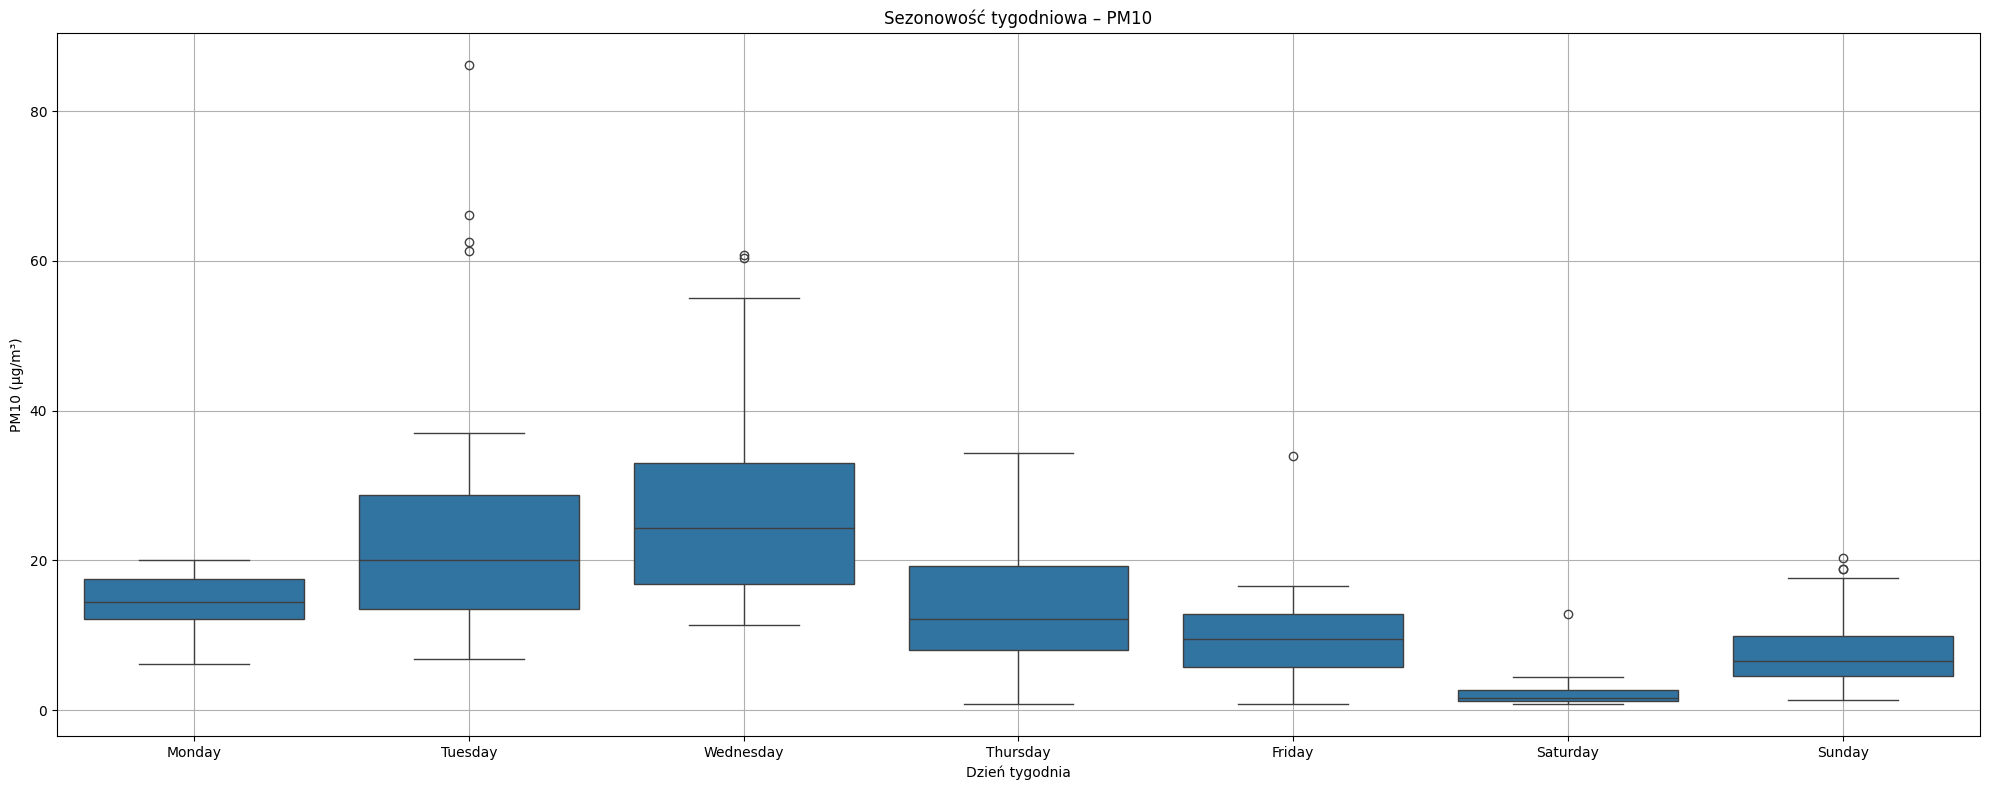

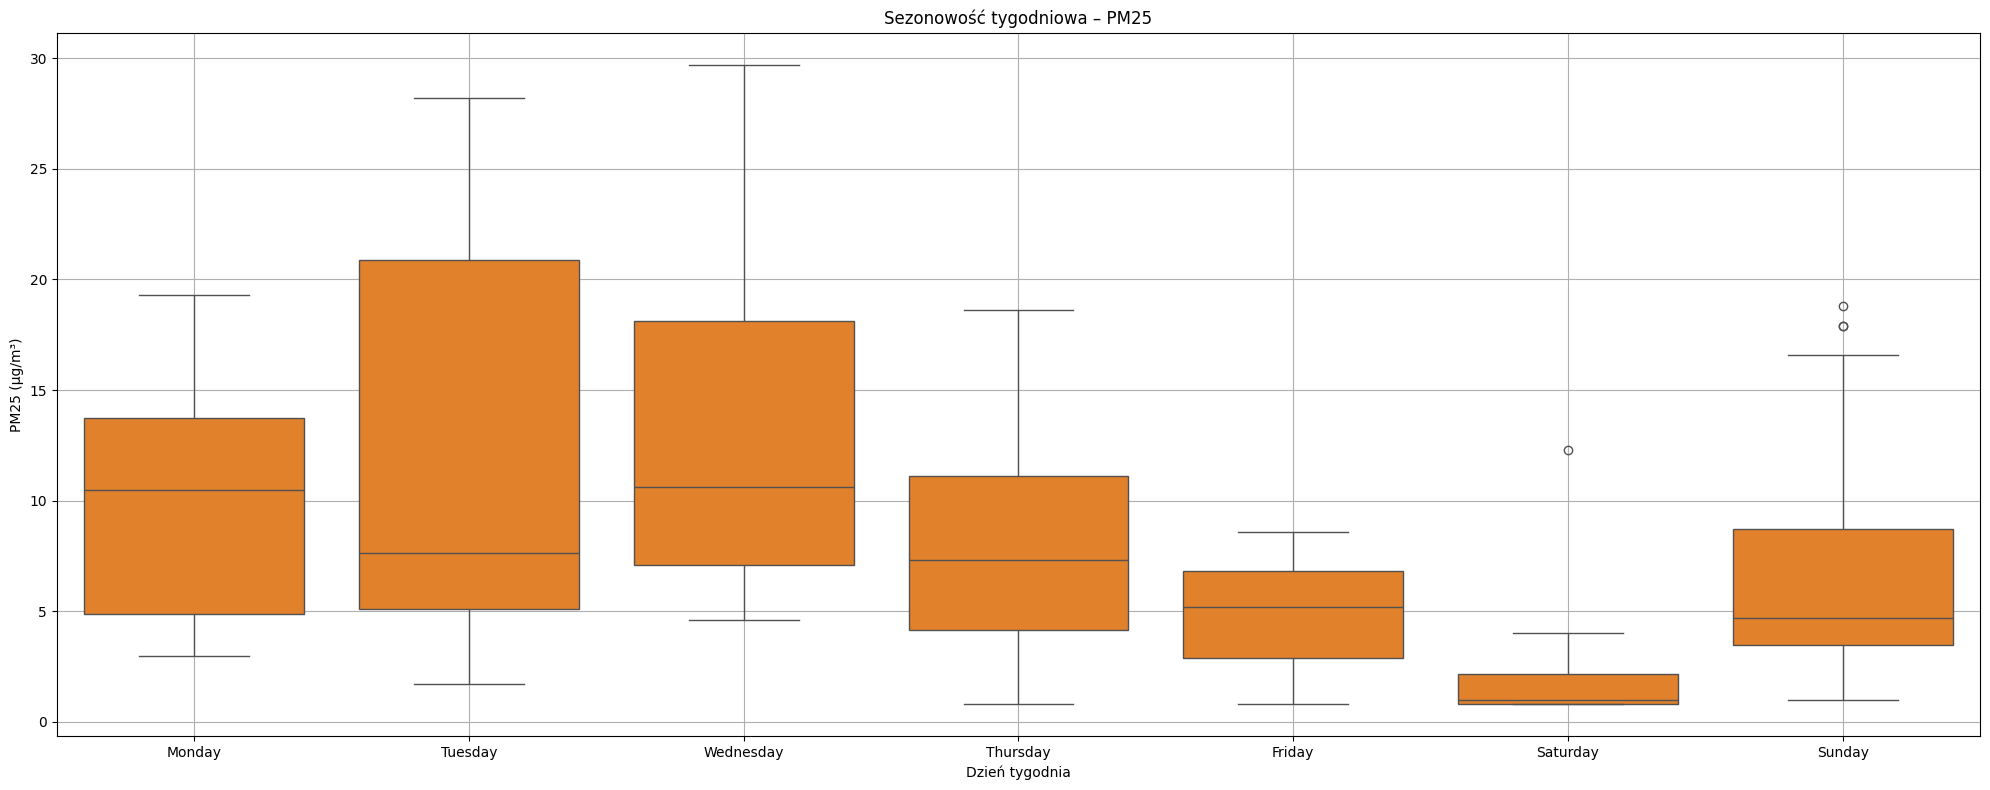

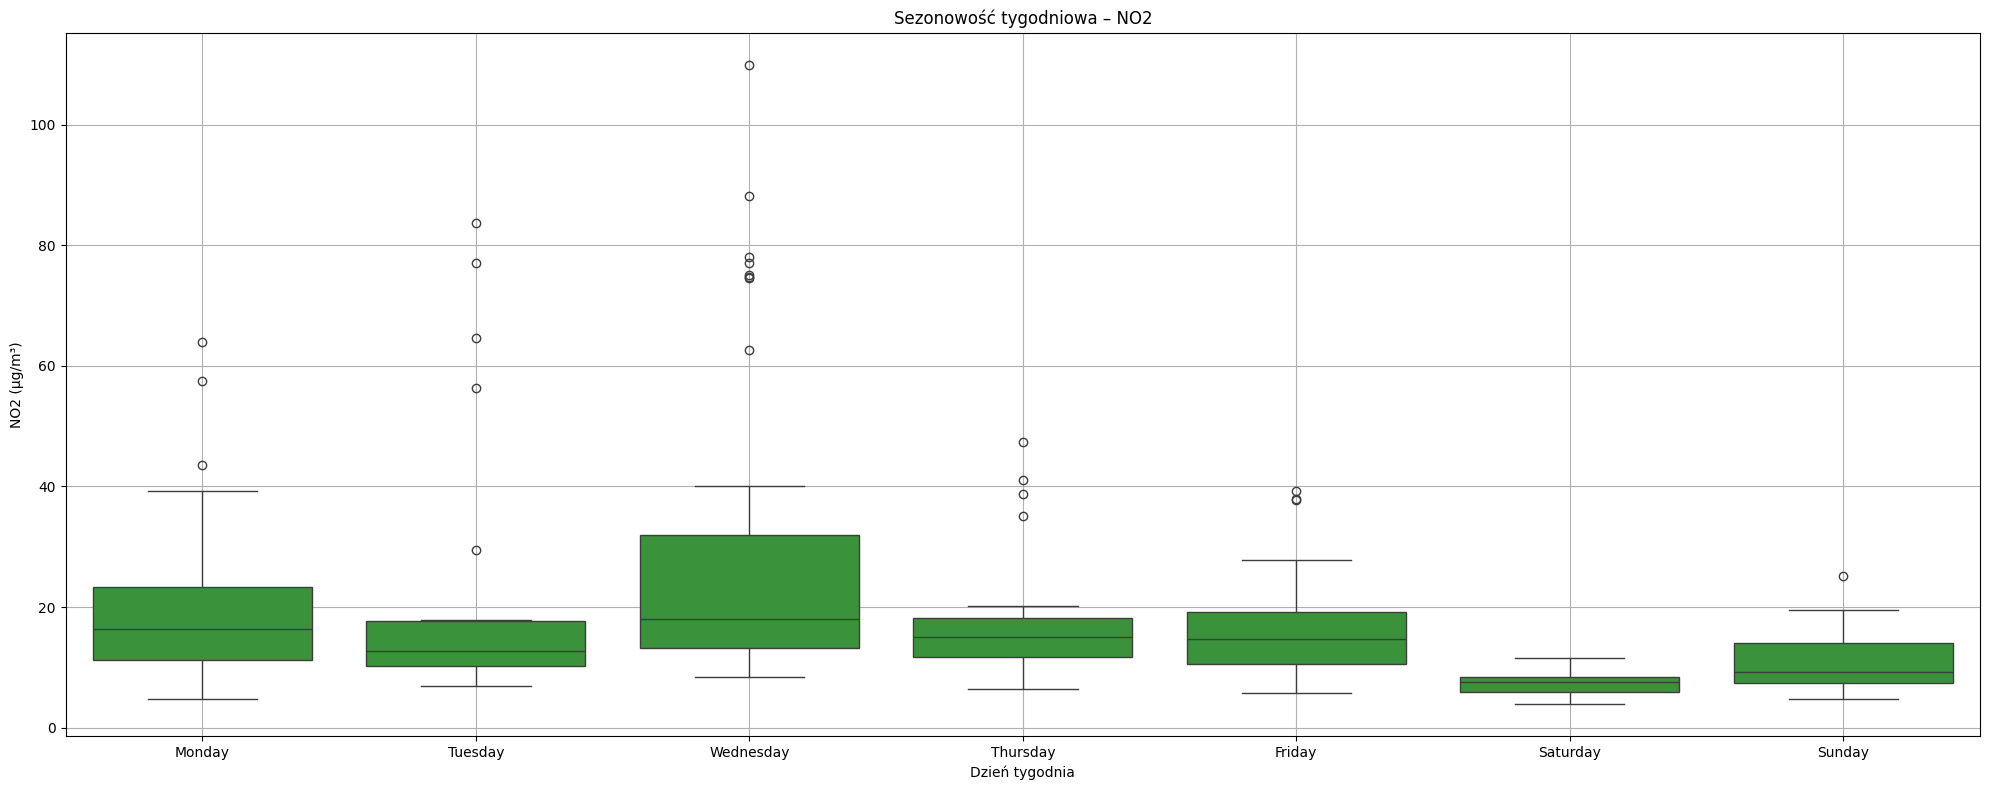

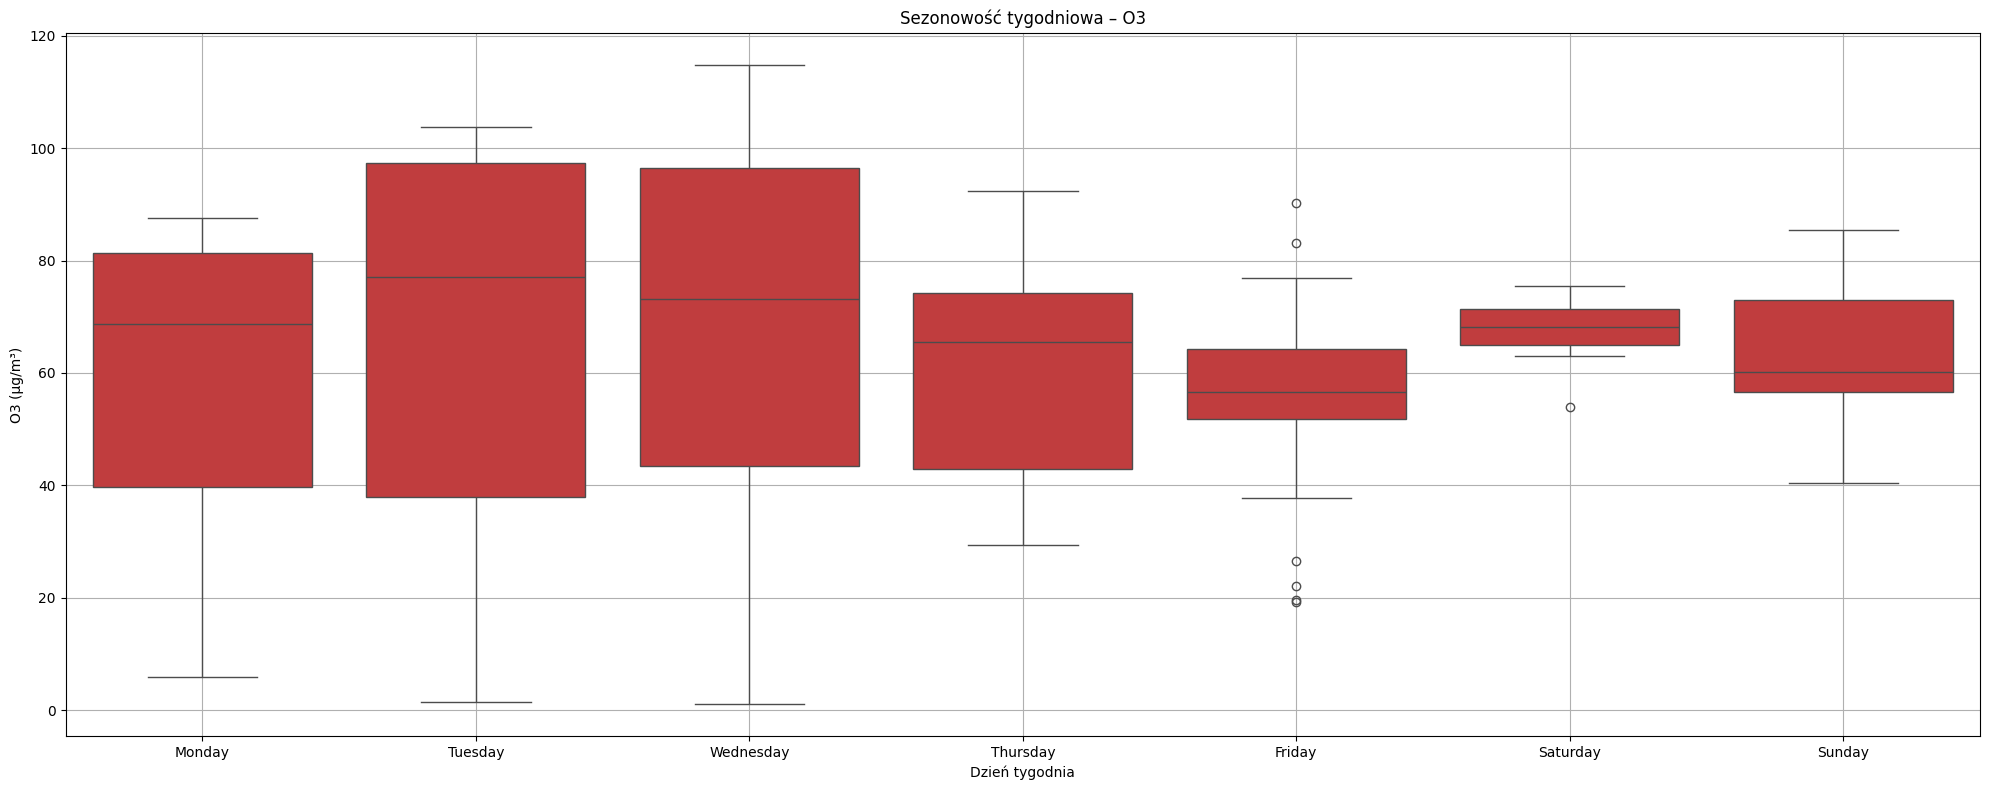

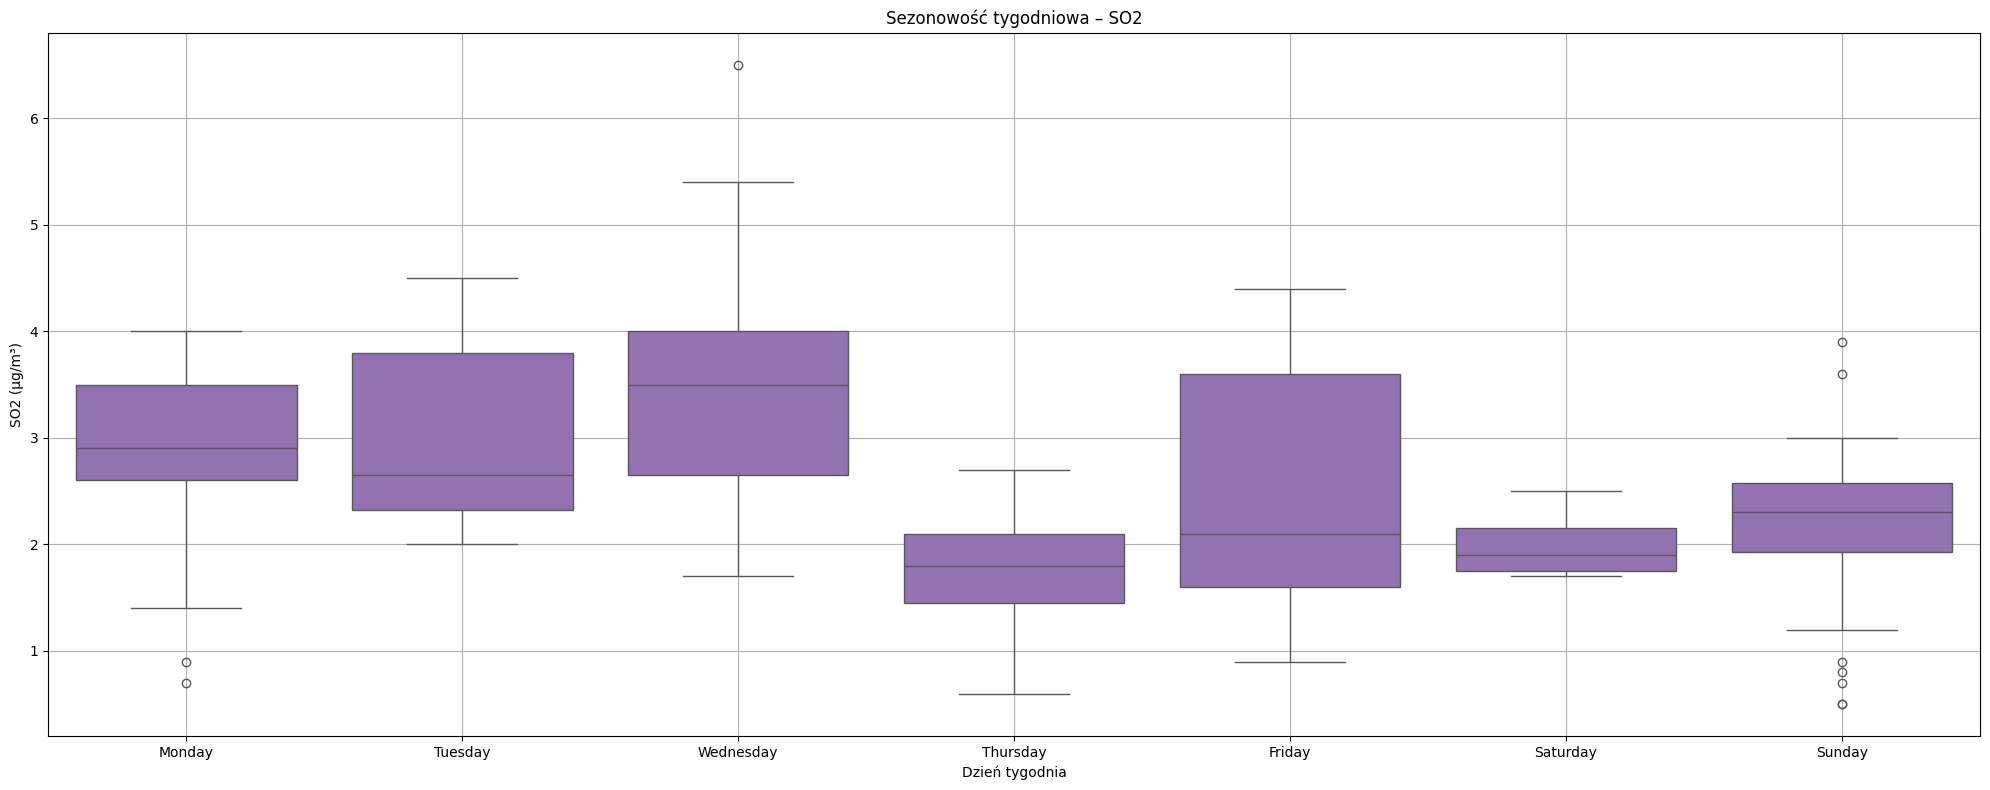

In [16]:
pdf_small['weekday'] = pdf_small.index.dayofweek 
pdf_small['weekday_name'] = pdf_small.index.day_name()

pollutants = ['pm10', 'pm25', 'no2', 'o3', 'so2']

for pollutant in pollutants:
    plt.figure(figsize=(20, 8))
    sns.boxplot(x='weekday_name', y=pollutant, data=pdf_small, color=pollutant_colors[pollutant], order=[
        'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
    ])
    plt.title(f'Sezonowość tygodniowa – {pollutant.upper()}')
    plt.xlabel('Dzień tygodnia')
    plt.ylabel(f'{pollutant.upper()} (µg/m³)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
pollutant_pallettes = {
    'pm10': 'YlGnBu',
    'pm25': 'Oranges',
    'no2': 'Greens', 
    'o3': 'YlOrRd',
    'so2': 'BuPu',
}

def plot_weekly_hourly_heatmap(pdf_to_plot, pollutant):
    if not isinstance(pdf_to_plot.index, pd.DatetimeIndex):
        pdf_to_plot = pdf_to_plot.set_index('datetime_utc')
    
    pdf_to_plot['hour'] = pdf_to_plot.index.hour
    pdf_to_plot['weekday_name'] = pdf_to_plot.index.day_name()

    pivot = pdf_to_plot.pivot_table(
        values=pollutant,
        index='hour',
        columns='weekday_name',
        aggfunc='mean'
    )

    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    pivot = pivot[days_order]

    plt.figure(figsize=(12, 8))
    sns.heatmap(
        pivot,
        cmap=pollutant_pallettes.get(pollutant, 'viridis'),
        linewidths=0.3
    )
    plt.title(f'Heatmapa godzin vs dni tygodnia dla {pollutant.upper()}')
    plt.xlabel('Dzień tygodnia')
    plt.ylabel('Godzina')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


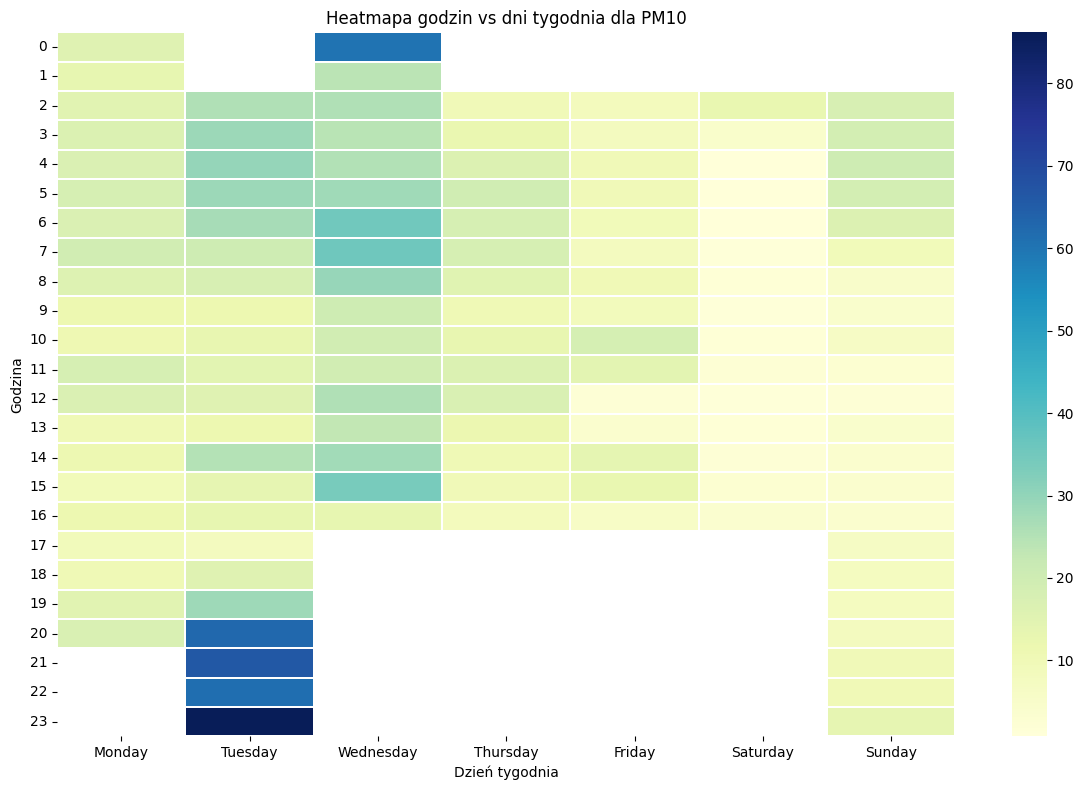

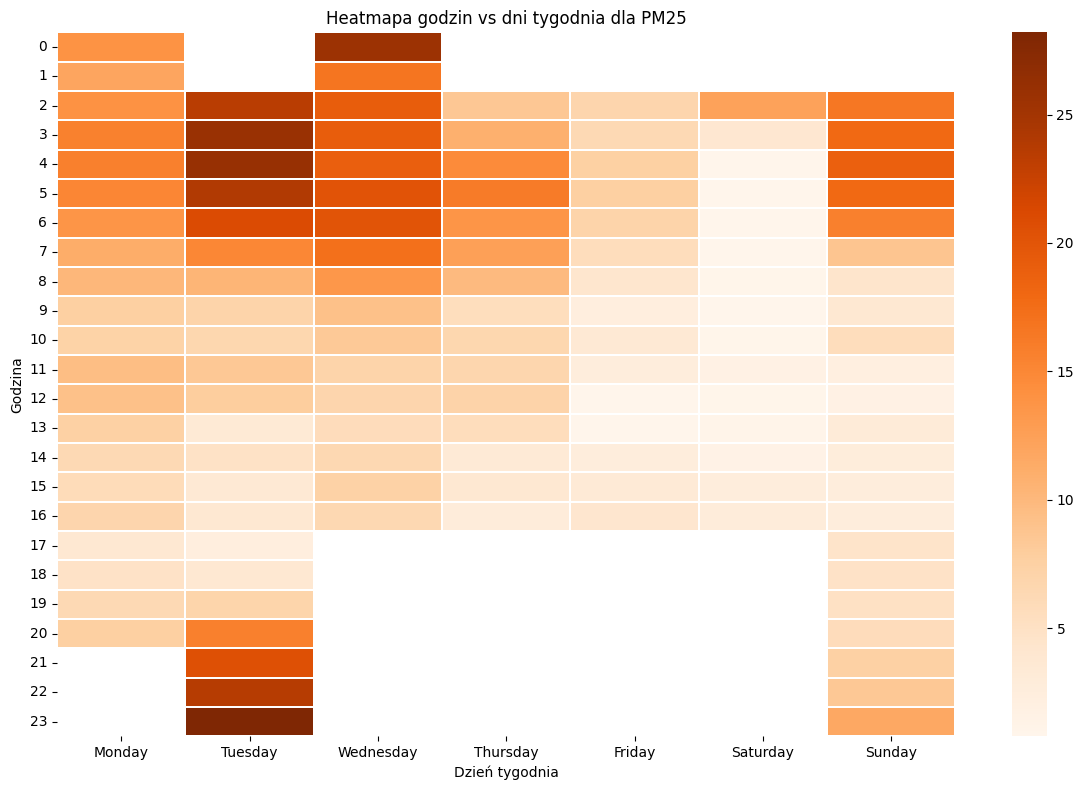

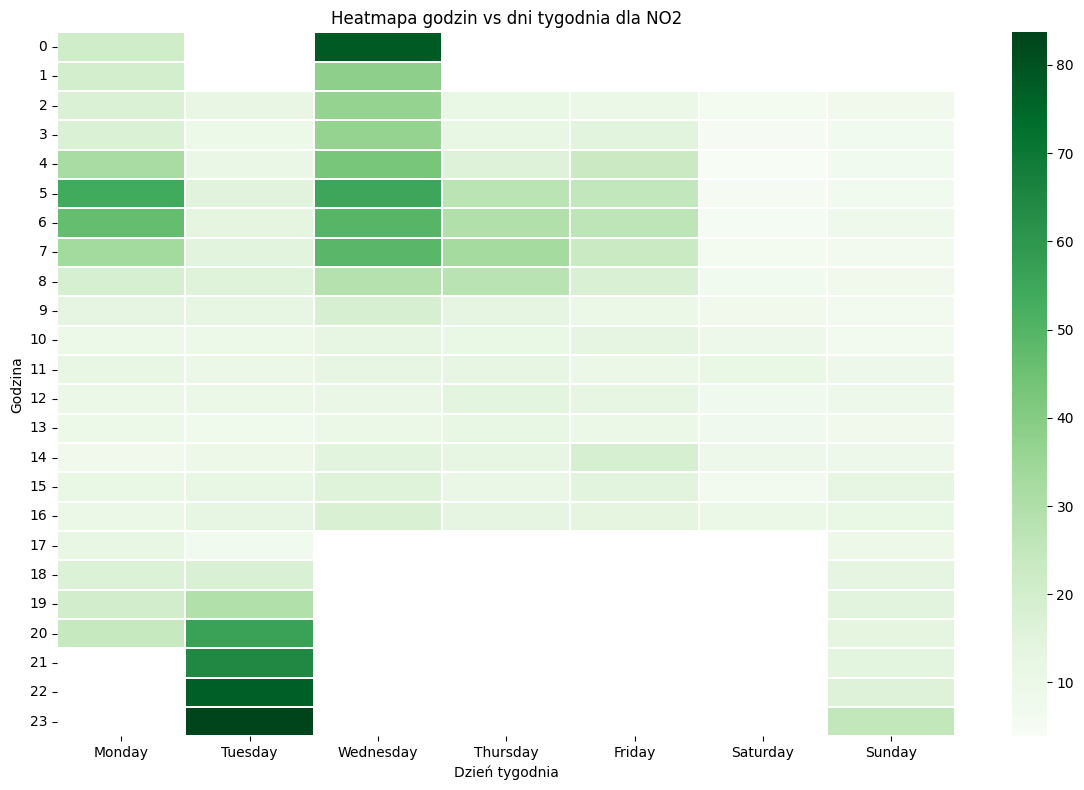

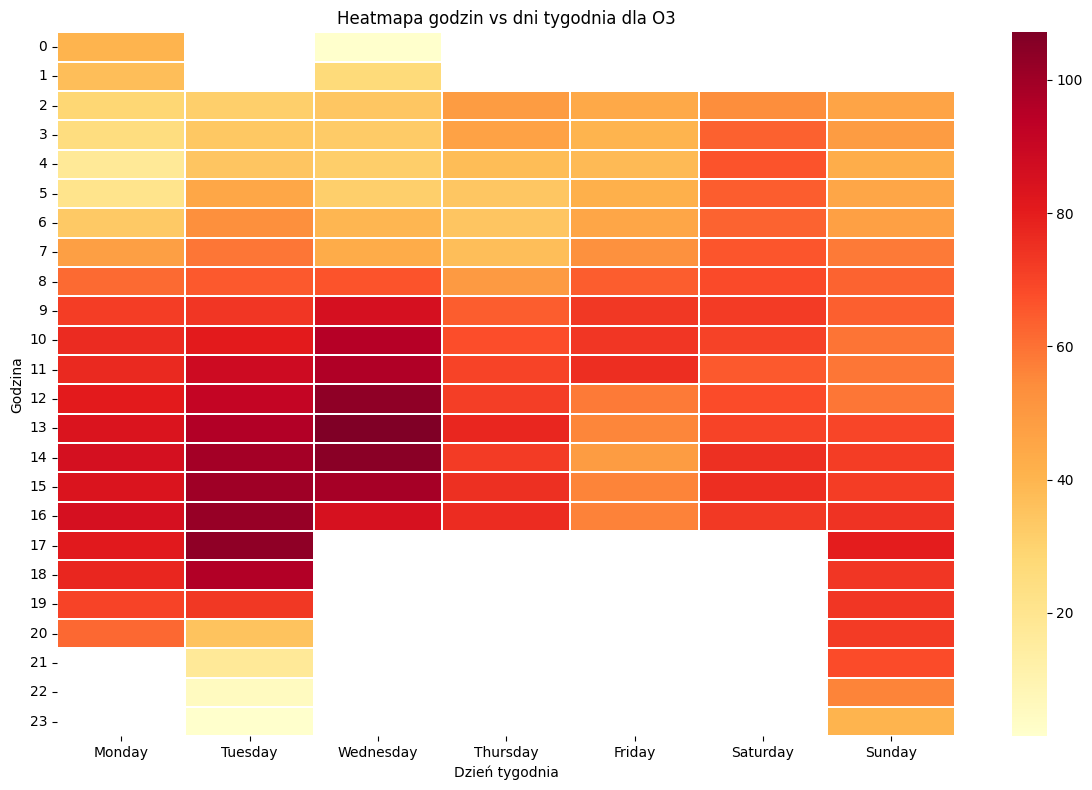

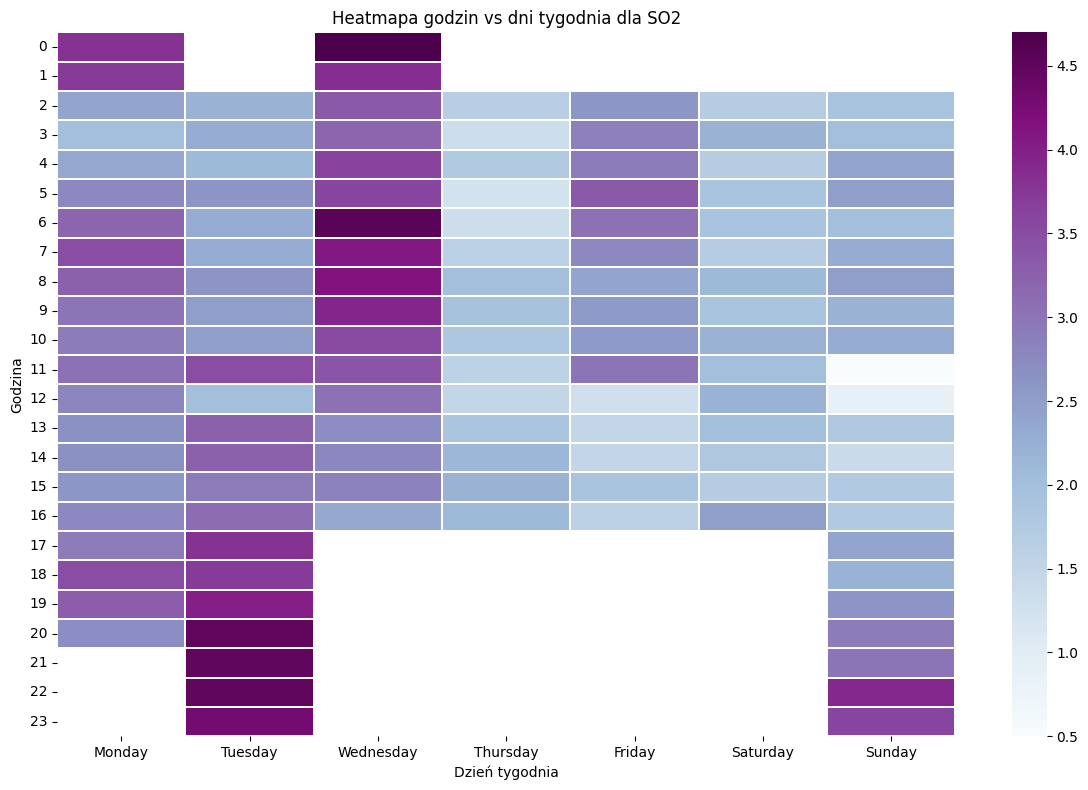

In [18]:
pollutants = ['pm10', 'pm25', 'no2', 'o3', 'so2']

for pol in pollutants:
    plot_weekly_hourly_heatmap(pdf.copy(), pol)

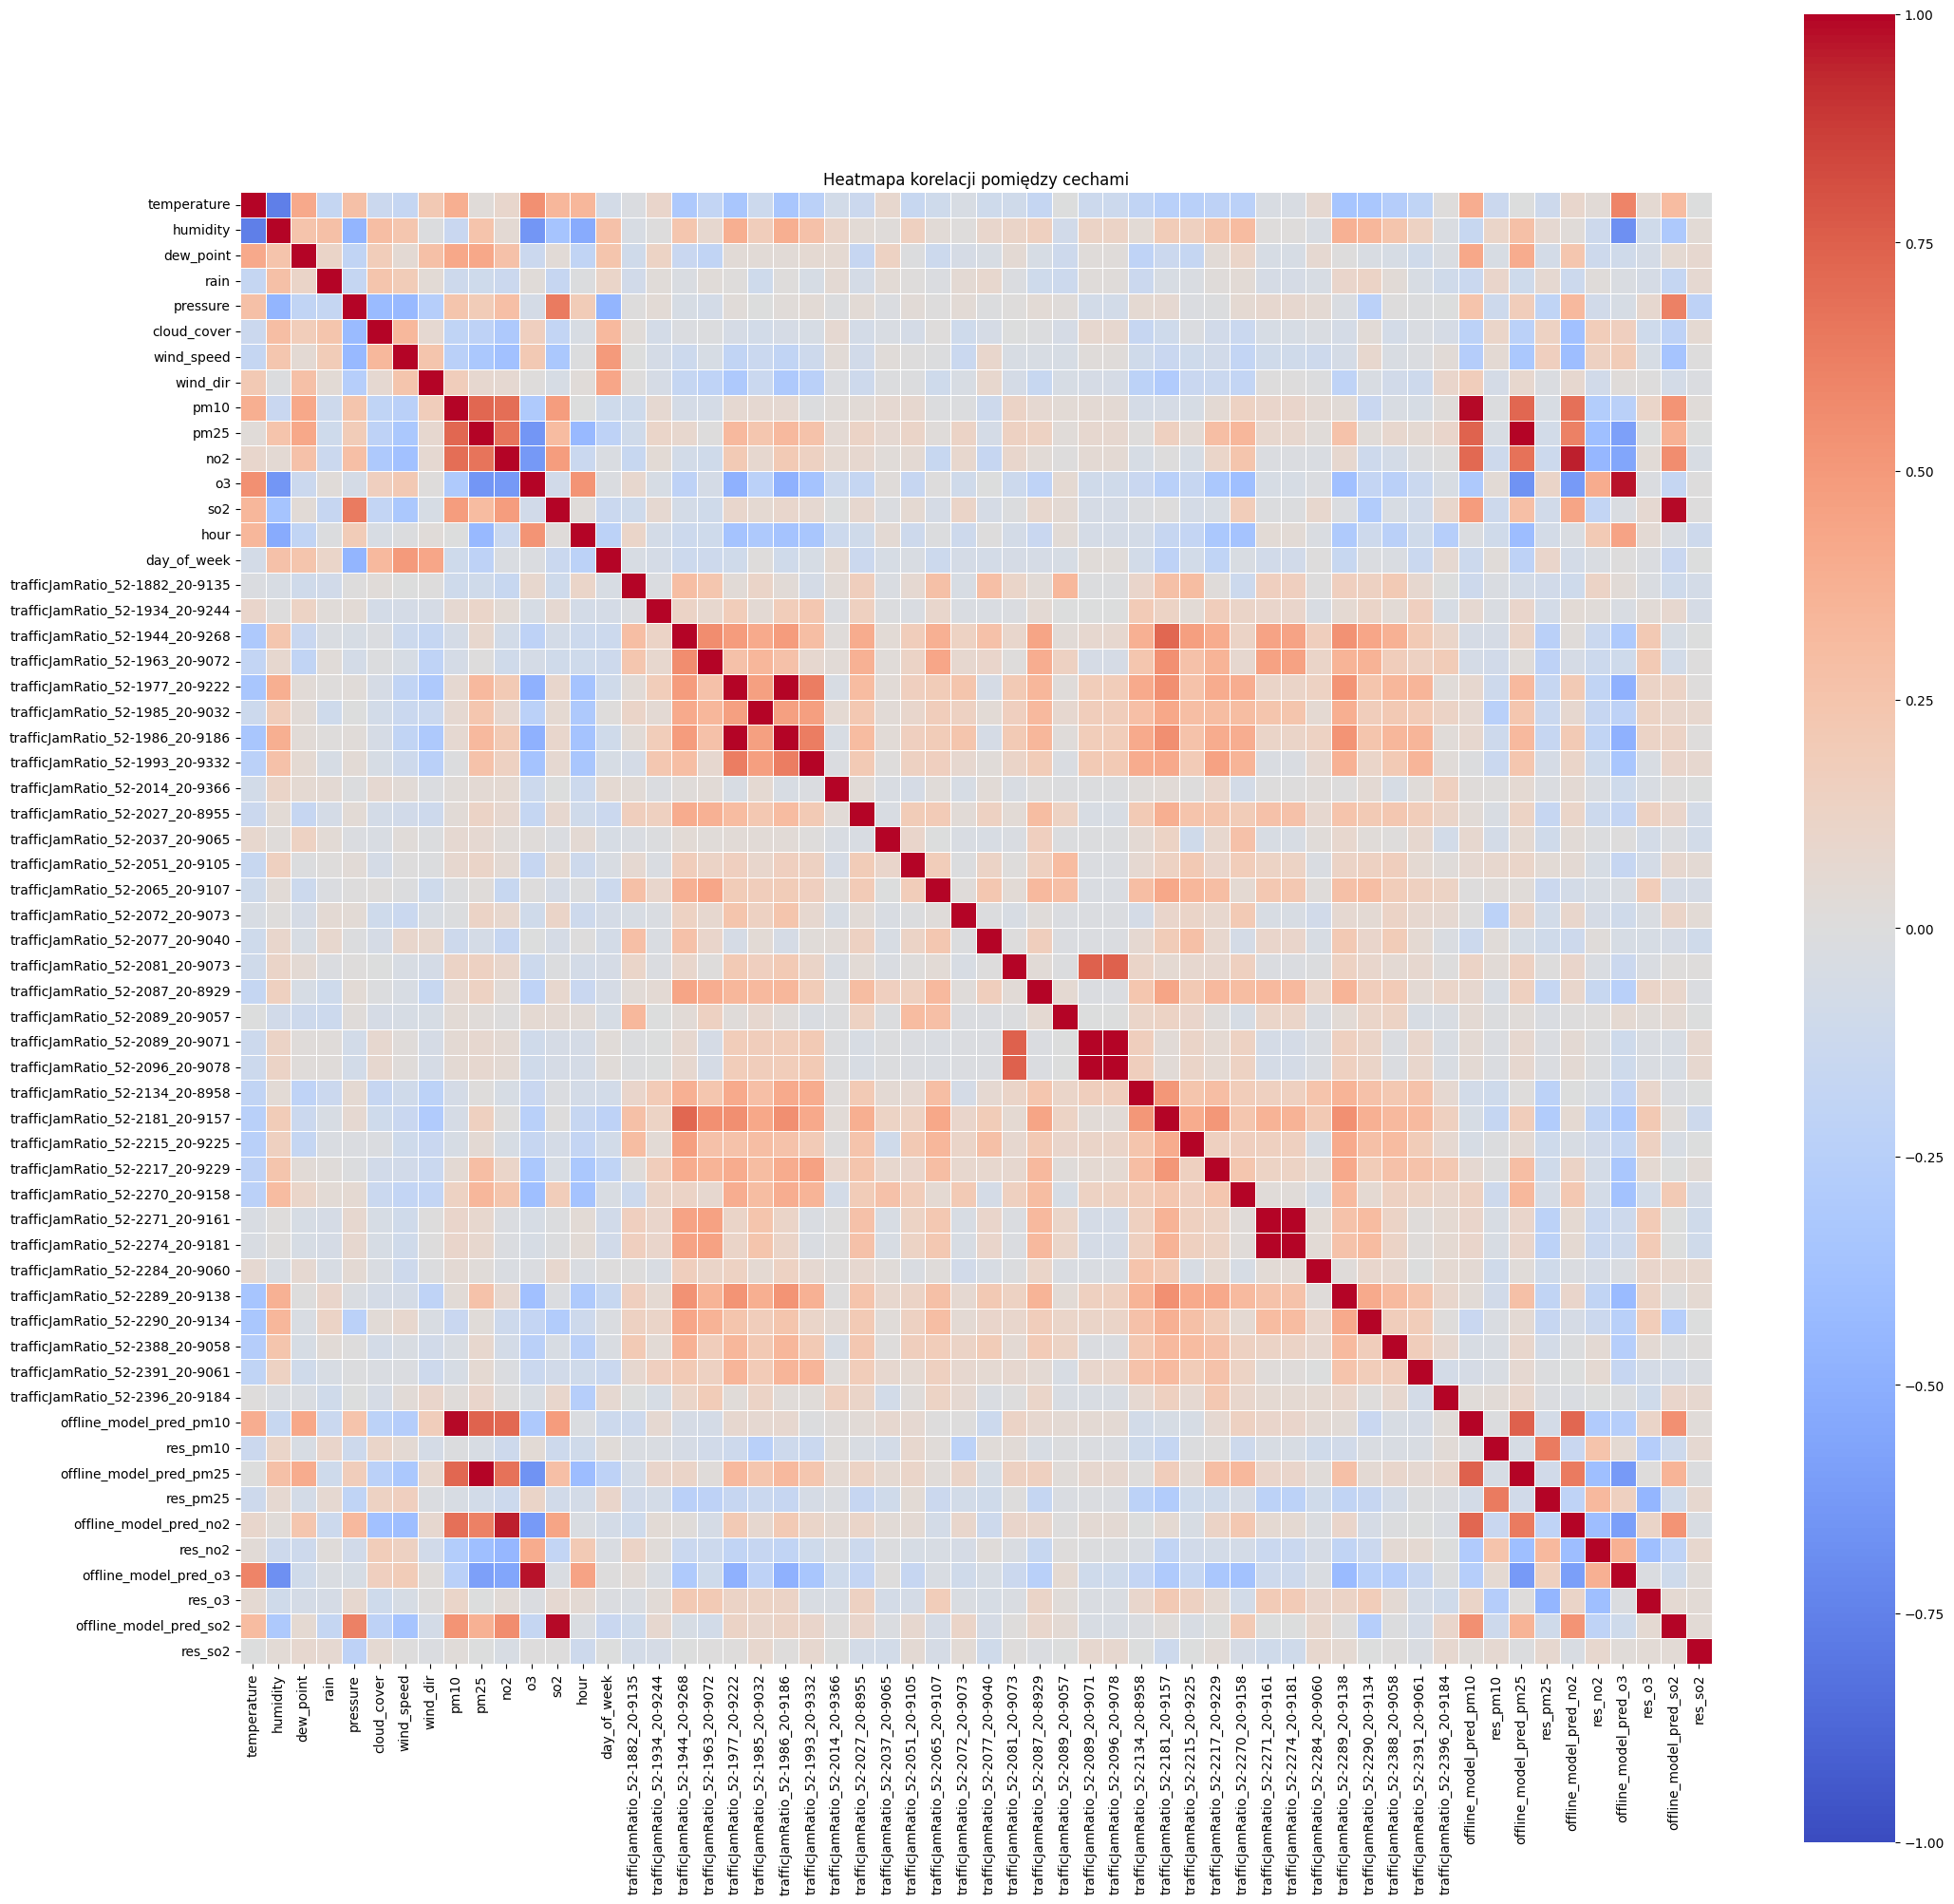

In [ ]:
cols_to_remove = [
    'datetime_utc', 'snowfall', 'year', 'month'
]

all_columns = df.columns
cols = [
    col for col in all_columns
    if col not in cols_to_remove
    and not col.endswith('_t-1')
    and not col.endswith('_t+1')
]


df_filtered = df.select(cols)
pdf_features = df_filtered.toPandas()

corr = pdf_features.corr()

plt.figure(figsize=(25, 25))
sns.heatmap(
    corr, 
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.5,
    vmin=-1,
    vmax=1
)

plt.title('Heatmapa korelacji pomiędzy cechami')
plt.show()

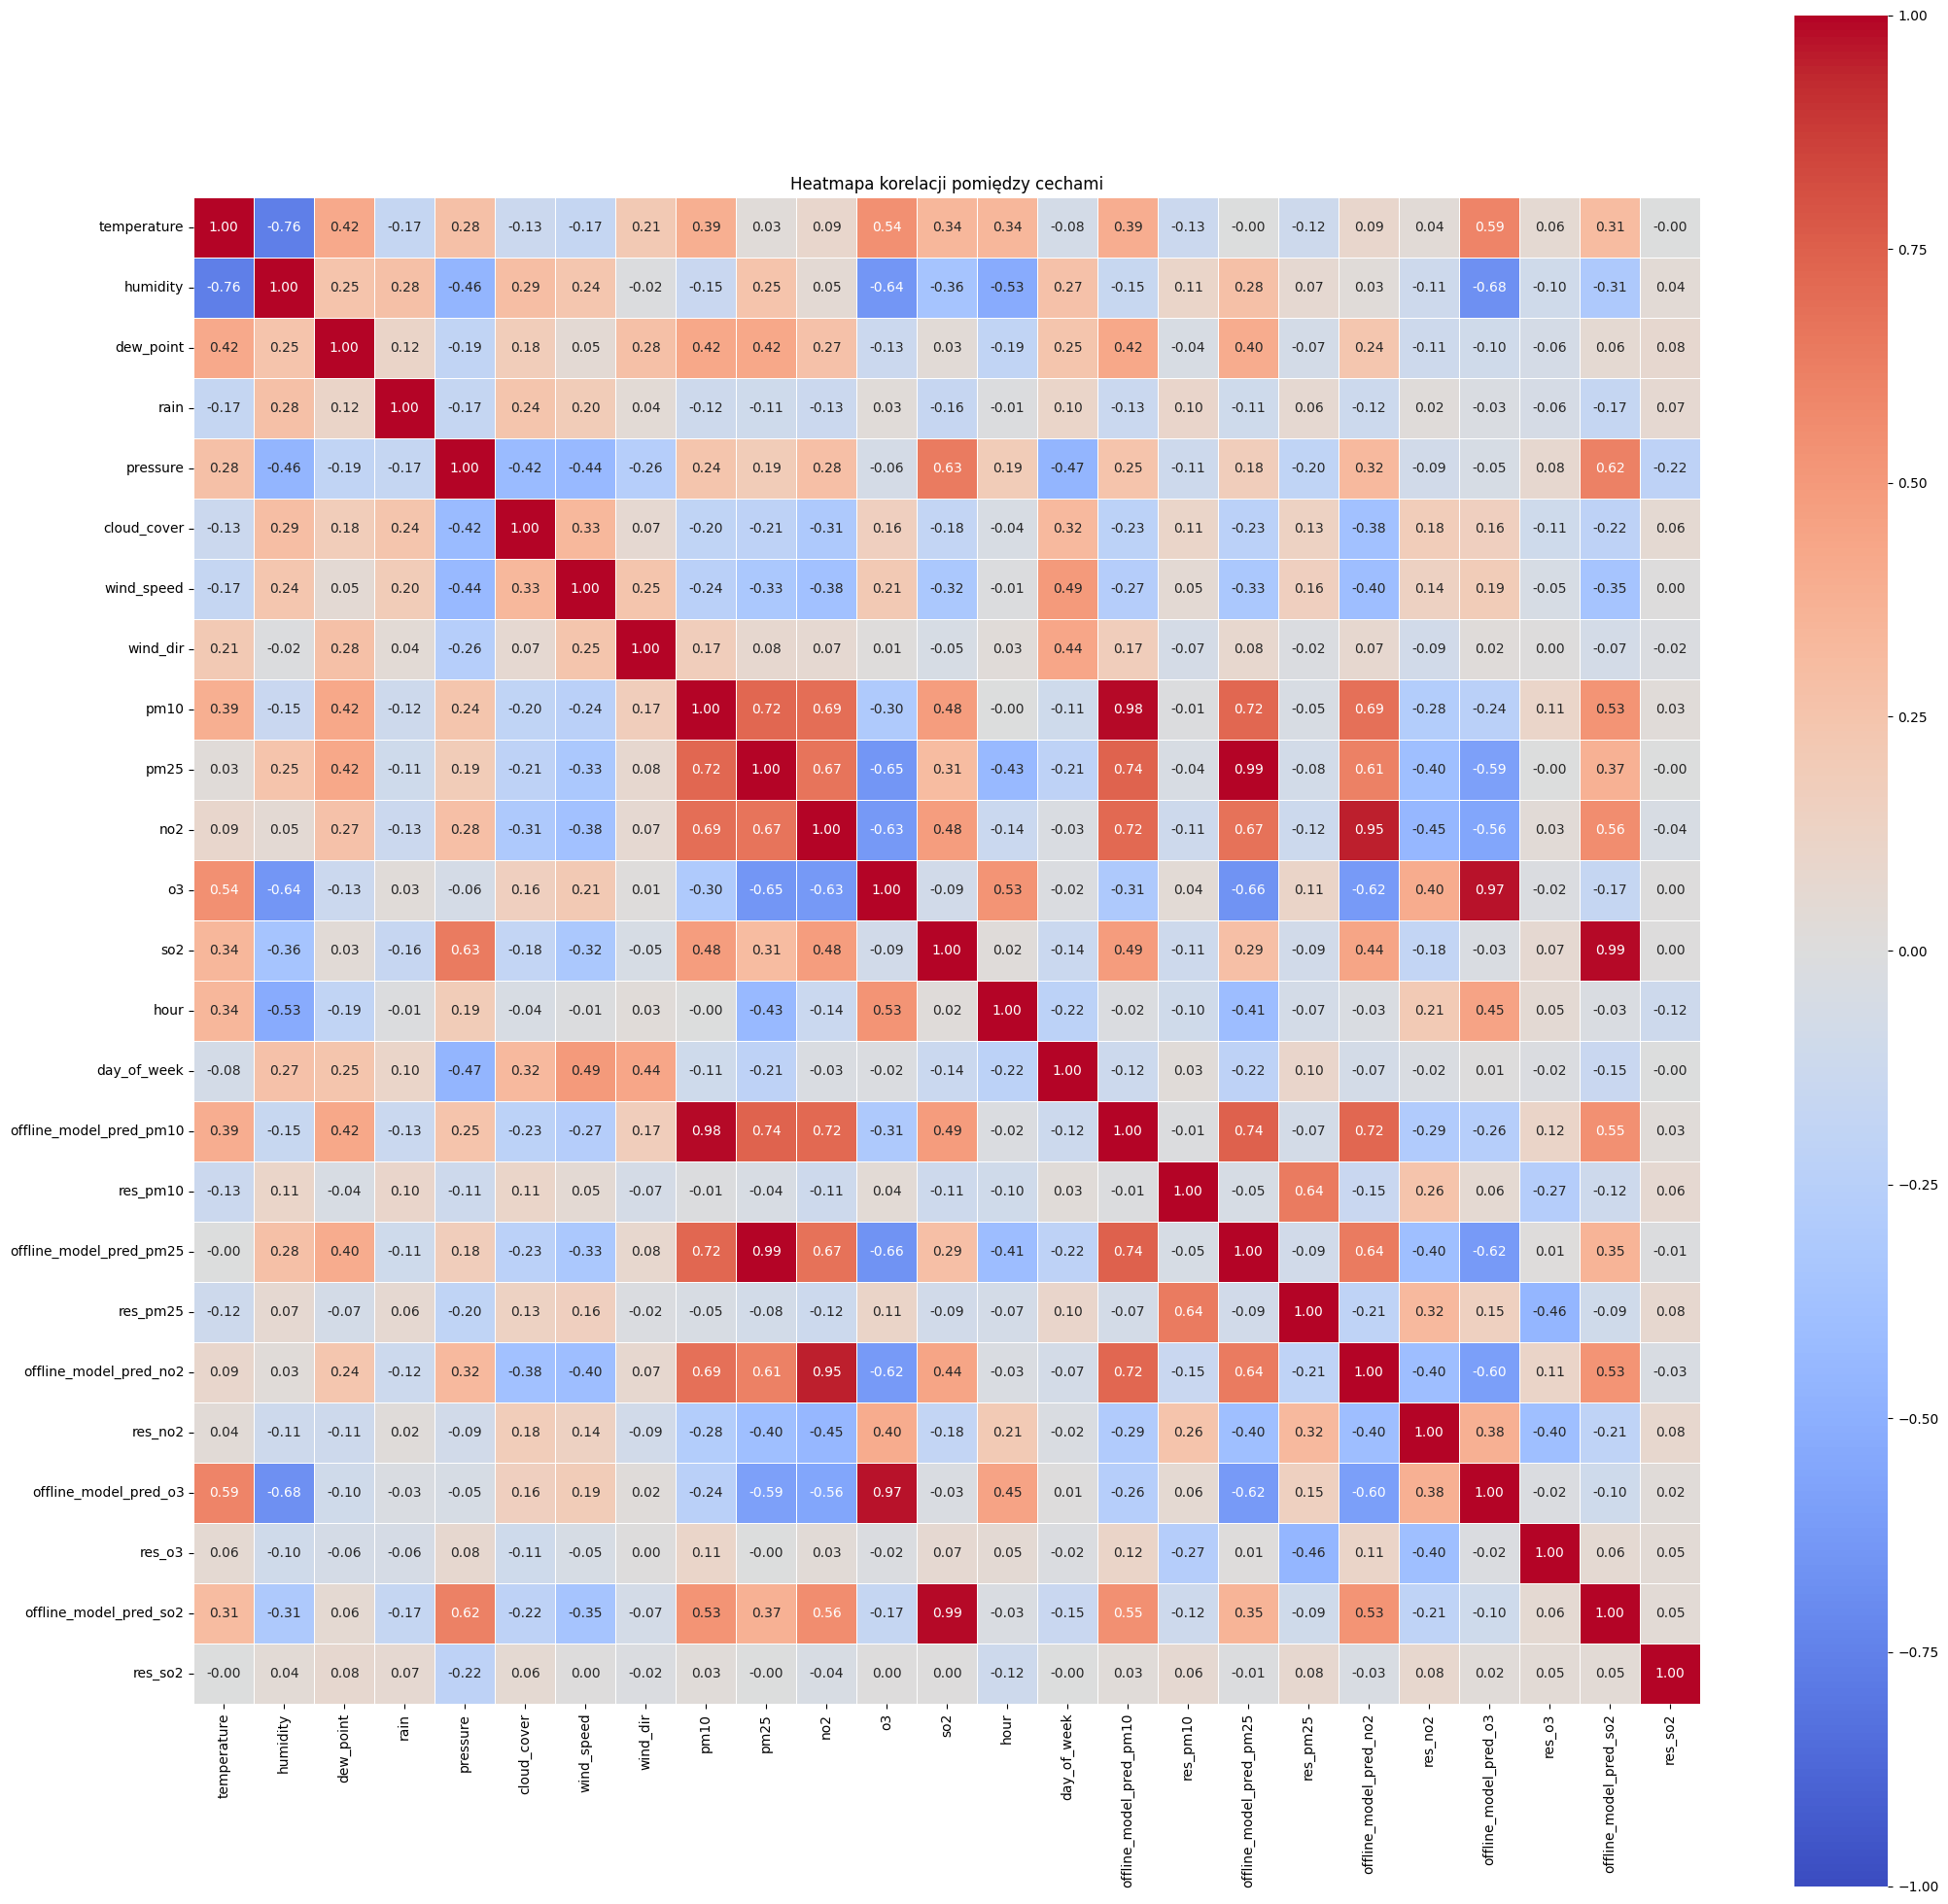

In [ ]:
cols_to_remove = [
    'datetime_utc', 'snowfall', 'year', 'month'
]

all_columns = df.columns
cols = [
    col for col in all_columns
    if col not in cols_to_remove
    and not col.endswith('_t-1')
    and not col.endswith('_t+1')
    and not col.startswith('trafficJamRatio')
]


df_filtered = df.select(cols)
pdf_features = df_filtered.toPandas()

corr = pdf_features.corr()

plt.figure(figsize=(25, 25))
sns.heatmap(
    corr, 
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.5,
    vmin=-1,
    vmax=1
)

plt.title('Heatmapa korelacji pomiędzy cechami')
plt.show()

<Figure size 2500x600 with 0 Axes>

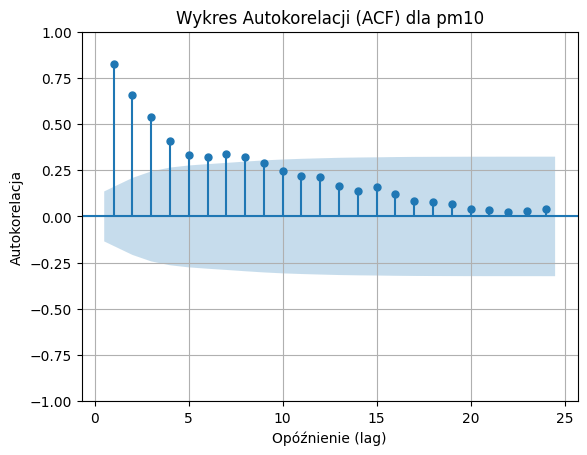

<Figure size 2500x600 with 0 Axes>

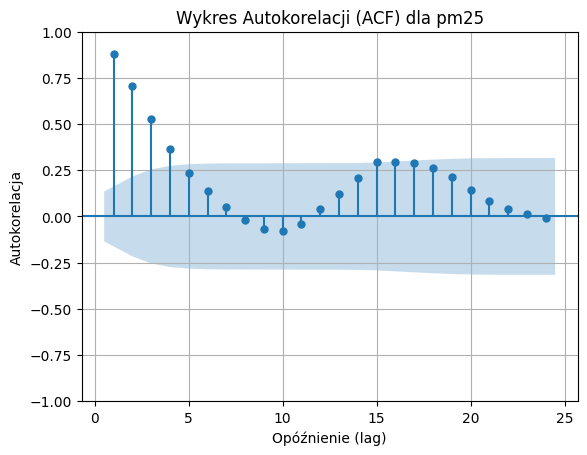

<Figure size 2500x600 with 0 Axes>

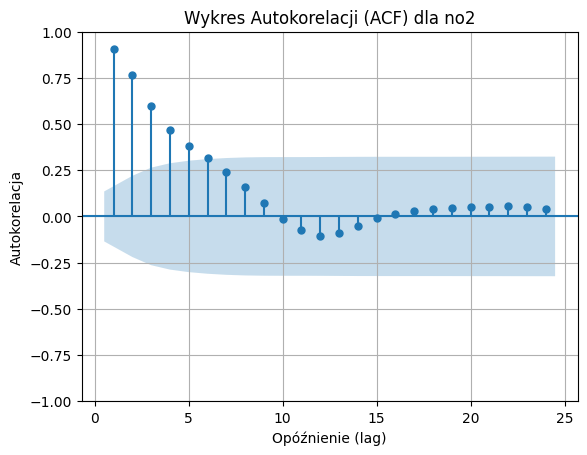

<Figure size 2500x600 with 0 Axes>

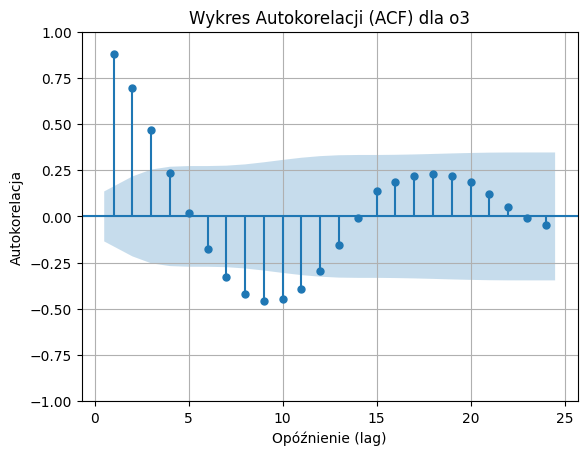

<Figure size 2500x600 with 0 Axes>

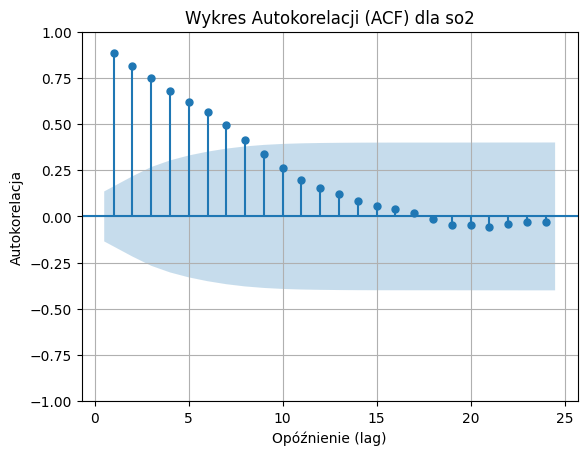

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

variables = ['pm10', 'pm25', 'no2', 'o3', 'so2']
for var in variables:
    plt.figure(figsize=(25, 6))
    plot_acf(pdf_features[var].dropna(), lags=24, zero=False)
    plt.title(f'Wykres Autokorelacji (ACF) dla {var}')
    plt.xlabel('Opóźnienie (lag)')
    plt.ylabel('Autokorelacja')
    plt.grid(True)
    plt.show()

<Figure size 1000x500 with 0 Axes>

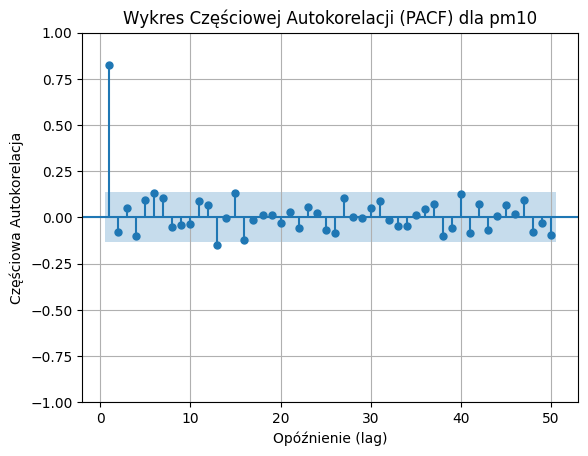

<Figure size 1000x500 with 0 Axes>

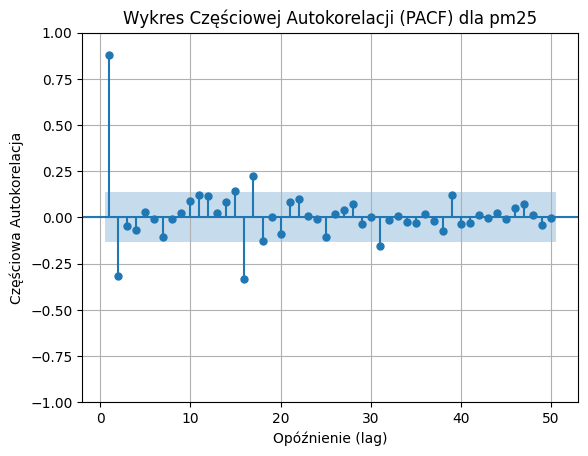

<Figure size 1000x500 with 0 Axes>

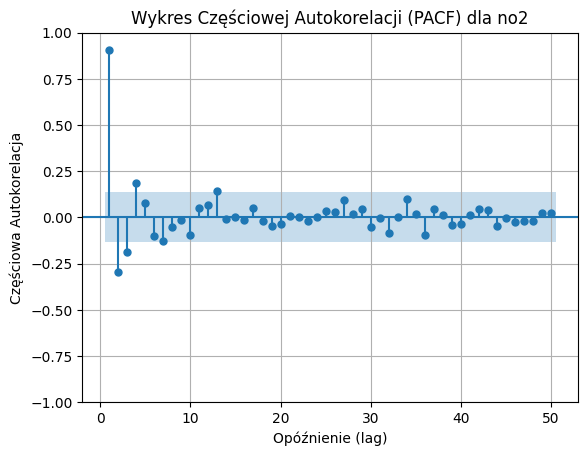

<Figure size 1000x500 with 0 Axes>

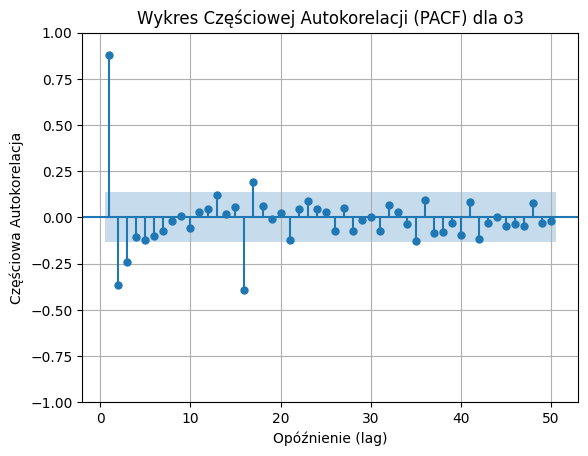

<Figure size 1000x500 with 0 Axes>

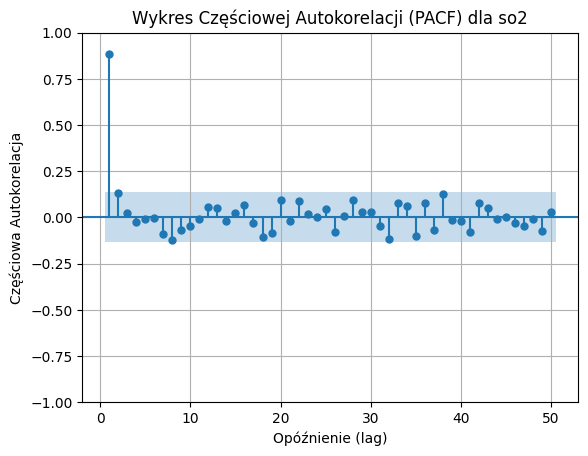

In [22]:
from statsmodels.graphics.tsaplots import plot_pacf

variables = ['pm10', 'pm25', 'no2', 'o3', 'so2']

for var in variables:
    plt.figure(figsize=(10, 5))
    plot_pacf(pdf_features[var].dropna(), lags=50, zero=False, method='ywm')
    plt.title(f'Wykres Częściowej Autokorelacji (PACF) dla {var}')
    plt.xlabel('Opóźnienie (lag)')
    plt.ylabel('Częściowa Autokorelacja')
    plt.grid(True)
    plt.show()
